# Univariate Time Series With Stacked LSTM, BiLSTM, and NeuralProphet

This notebook is V.2 with NeuralProphet added!
---

with V.2 some changes made as well.

* This notebook is generated for the article: Univariate Time Series With Stacked LSTM, BiLSTM, and NeuralProphet.

# Import libraries

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn.metrics as metrics
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load stock data & preprosses

In [ ]:
data = pd.read_csv("AAPL.csv")
print(data.head())


         Date      Open      High       Low     Close  Adj Close     Volume
0  2010-01-04  7.622500  7.660714  7.585000  7.643214   6.562589  493729600
1  2010-01-05  7.664286  7.699643  7.616071  7.656429   6.573936  601904800
2  2010-01-06  7.656429  7.686786  7.526786  7.534643   6.469368  552160000
3  2010-01-07  7.562500  7.571429  7.466071  7.520714   6.457407  477131200
4  2010-01-08  7.510714  7.571429  7.466429  7.570714   6.500340  447610800


In [ ]:
df = pd.read_csv('AAPL.csv')
df.shape
df

Date        Open        High  ...       Close   Adj Close     Volume
0     2010-01-04    7.622500    7.660714  ...    7.643214    6.562589  493729600
1     2010-01-05    7.664286    7.699643  ...    7.656429    6.573936  601904800
2     2010-01-06    7.656429    7.686786  ...    7.534643    6.469368  552160000
3     2010-01-07    7.562500    7.571429  ...    7.520714    6.457407  477131200
4     2010-01-08    7.510714    7.571429  ...    7.570714    6.500340  447610800
...          ...         ...         ...  ...         ...         ...        ...
2975  2021-10-27  149.360001  149.729996  ...  148.850006  148.850006   56094900
2976  2021-10-28  149.820007  153.169998  ...  152.570007  152.570007  100077900
2977  2021-10-29  147.220001  149.940002  ...  149.800003  149.800003  124850400
2978  2021-11-01  148.990005  149.699997  ...  148.960007  148.960007   74445600
2979  2021-11-02  148.660004  151.570007  ...  150.580002  150.580002   50453753

[2980 rows x 7 columns]

In [ ]:
df.duplicated().sum().any()

False

In [ ]:
sum(df.duplicated())

0

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2980 entries, 0 to 2979
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2980 non-null   object 
 1   Open       2980 non-null   float64
 2   High       2980 non-null   float64
 3   Low        2980 non-null   float64
 4   Close      2980 non-null   float64
 5   Adj Close  2980 non-null   float64
 6   Volume     2980 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 163.1+ KB


preprossesing 

In [ ]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    return summary


resumetable(df)

Dataset Shape: (2980, 7)


Name   dtypes  Missing  Uniques
0       Date   object        0     2980
1       Open  float64        0     2856
2       High  float64        0     2837
3        Low  float64        0     2853
4      Close  float64        0     2862
5  Adj Close  float64        0     2939
6     Volume    int64        0     2973

In [ ]:
df.describe()

Open         High  ...    Adj Close        Volume
count  2980.000000  2980.000000  ...  2980.000000  2.980000e+03
mean     41.024595    41.444840  ...    39.343258  2.726309e+08
std      35.489778    35.893334  ...    36.036754  2.265477e+08
min       6.870357     7.000000  ...     5.889190  4.544800e+07
25%      18.336607    18.557768  ...    16.060280  1.106592e+08
50%      28.048750    28.316250  ...    25.920846  1.869154e+08
75%      47.373126    47.687499  ...    45.945326  3.734612e+08
max     156.979996   157.259995  ...   156.690002  1.880998e+09

[8 rows x 6 columns]

In [ ]:
df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [ ]:
print(df.corr())

               Open      High       Low     Close  Adj Close    Volume
Open       1.000000  0.999897  0.999853  0.999753   0.999648 -0.483814
High       0.999897  1.000000  0.999818  0.999871   0.999774 -0.482251
Low        0.999853  0.999818  1.000000  0.999874   0.999770 -0.486630
Close      0.999753  0.999871  0.999874  1.000000   0.999898 -0.484570
Adj Close  0.999648  0.999774  0.999770  0.999898   1.000000 -0.483597
Volume    -0.483814 -0.482251 -0.486630 -0.484570  -0.483597  1.000000


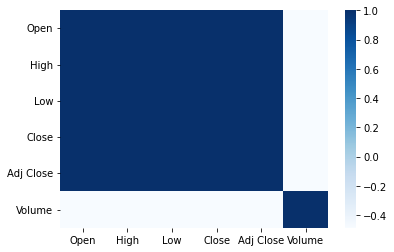

In [ ]:
sns.heatmap(df.corr(), cmap=("Blues"))

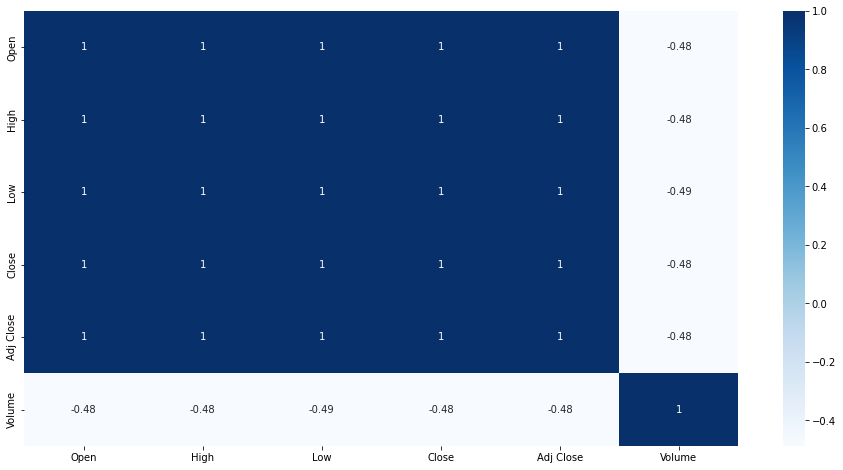

In [ ]:
plt.figure(figsize=(16,8))

# heatmap
sns.heatmap(df.corr(), cmap="Blues", annot=True)
plt.show()                           

Text(0.5, 1.0, 'Correlation between Close and Volume')

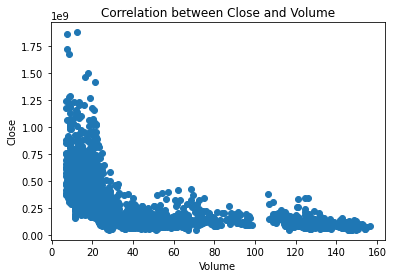

In [ ]:
plt.scatter(df['Close'], df['Volume'])
plt.ylabel("Close")
plt.xlabel("Volume")
plt.title("Correlation between Close and Volume")

Text(0.5, 1.0, 'Correlation between High and Low')

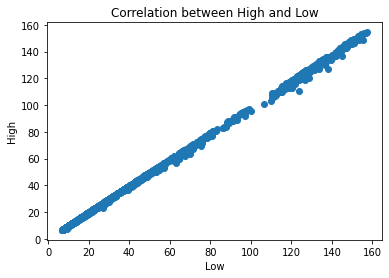

In [ ]:
plt.scatter(df['High'], df['Low'])
plt.ylabel("High")
plt.xlabel("Low")
plt.title("Correlation between High and Low")

EDA

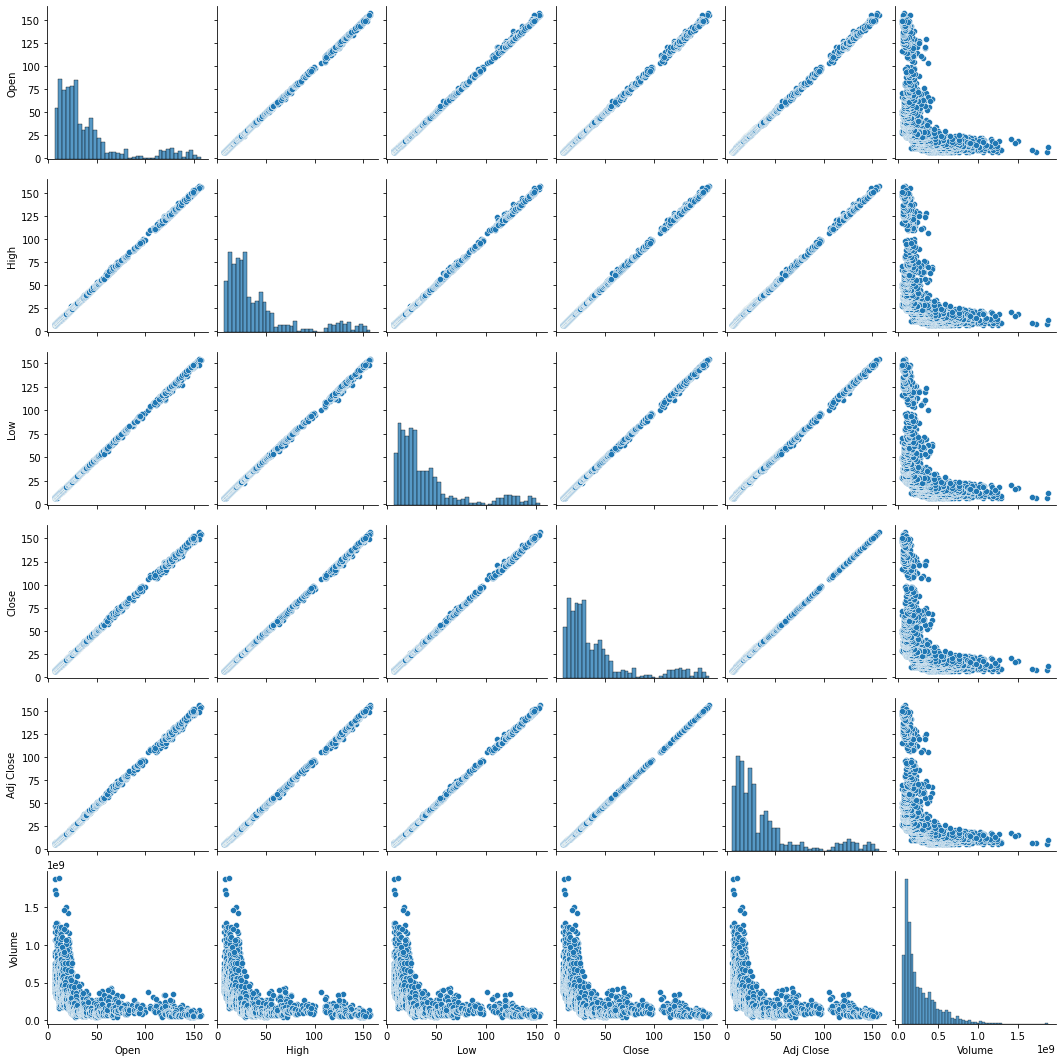

In [ ]:
sns.pairplot(df)

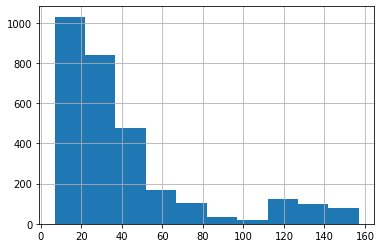

In [ ]:
df['Open'].hist()

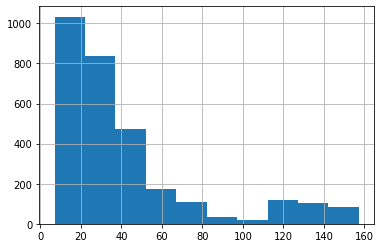

In [ ]:
df['High'].hist()

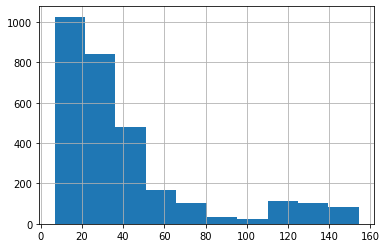

In [ ]:
df['Low'].hist()

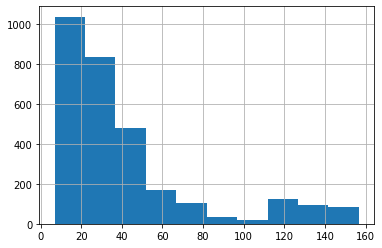

In [ ]:
df['Close'].hist()

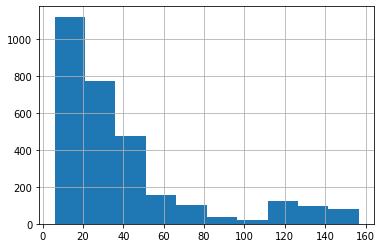

In [ ]:
df['Adj Close'].hist()

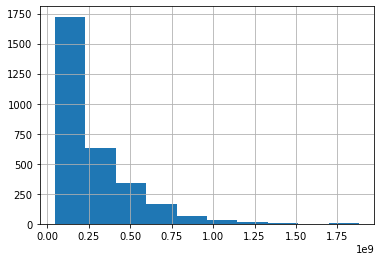

In [ ]:
df['Volume'].hist()

In [ ]:
df

Date        Open        High  ...       Close   Adj Close     Volume
0     2010-01-04    7.622500    7.660714  ...    7.643214    6.562589  493729600
1     2010-01-05    7.664286    7.699643  ...    7.656429    6.573936  601904800
2     2010-01-06    7.656429    7.686786  ...    7.534643    6.469368  552160000
3     2010-01-07    7.562500    7.571429  ...    7.520714    6.457407  477131200
4     2010-01-08    7.510714    7.571429  ...    7.570714    6.500340  447610800
...          ...         ...         ...  ...         ...         ...        ...
2975  2021-10-27  149.360001  149.729996  ...  148.850006  148.850006   56094900
2976  2021-10-28  149.820007  153.169998  ...  152.570007  152.570007  100077900
2977  2021-10-29  147.220001  149.940002  ...  149.800003  149.800003  124850400
2978  2021-11-01  148.990005  149.699997  ...  148.960007  148.960007   74445600
2979  2021-11-02  148.660004  151.570007  ...  150.580002  150.580002   50453753

[2980 rows x 7 columns]

In [ ]:
import plotly.graph_objects as go
figure = go.Figure(data=[go.Candlestick(x=data["Date"],
                                        open=data["Open"], high=data["High"],
                                        low=data["Low"], close=data["Close"])])
figure.update_layout(title = "Apple Stock Price Analysis", xaxis_rangeslider_visible=False)
figure.show()

# EDA

In [ ]:
data = pd.read_csv("AAPL.csv")
print(data.head())
data.info()

         Date      Open      High       Low     Close  Adj Close     Volume
0  2010-01-04  7.622500  7.660714  7.585000  7.643214   6.562589  493729600
1  2010-01-05  7.664286  7.699643  7.616071  7.656429   6.573936  601904800
2  2010-01-06  7.656429  7.686786  7.526786  7.534643   6.469368  552160000
3  2010-01-07  7.562500  7.571429  7.466071  7.520714   6.457407  477131200
4  2010-01-08  7.510714  7.571429  7.466429  7.570714   6.500340  447610800
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2980 entries, 0 to 2979
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2980 non-null   object 
 1   Open       2980 non-null   float64
 2   High       2980 non-null   float64
 3   Low        2980 non-null   float64
 4   Close      2980 non-null   float64
 5   Adj Close  2980 non-null   float64
 6   Volume     2980 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 163.1+ KB


In [ ]:
data.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [ ]:
data['Date'] = pd.to_datetime(data['Date'], infer_datetime_format=True)

In [ ]:
%matplotlib inline
from matplotlib.pylab import rcParams
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [ ]:

data=data.set_index(['Date'])
data.head()

Open      High       Low     Close  Adj Close     Volume
Date                                                                    
2010-01-04  7.622500  7.660714  7.585000  7.643214   6.562589  493729600
2010-01-05  7.664286  7.699643  7.616071  7.656429   6.573936  601904800
2010-01-06  7.656429  7.686786  7.526786  7.534643   6.469368  552160000
2010-01-07  7.562500  7.571429  7.466071  7.520714   6.457407  477131200
2010-01-08  7.510714  7.571429  7.466429  7.570714   6.500340  447610800

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2980 entries, 2010-01-04 to 2021-11-02
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2980 non-null   float64
 1   High       2980 non-null   float64
 2   Low        2980 non-null   float64
 3   Close      2980 non-null   float64
 4   Adj Close  2980 non-null   float64
 5   Volume     2980 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 163.0 KB


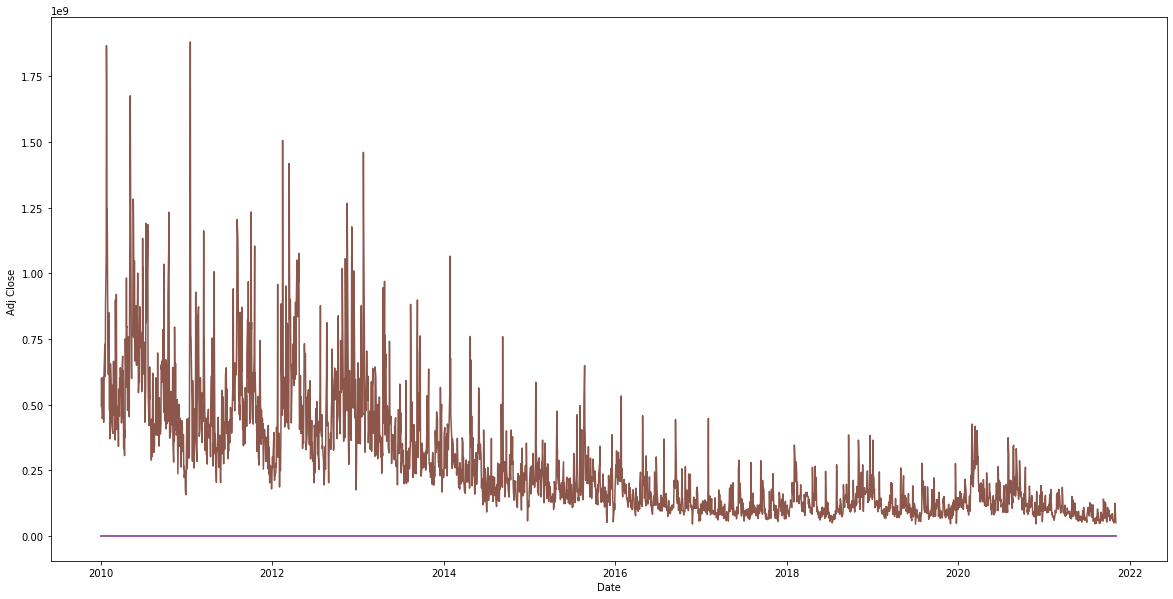

In [ ]:
plt.figure(figsize=(20,10))
plt.xlabel("Date")
plt.ylabel("Adj Close ")
plt.plot(data)

In [ ]:
rolmean=data.rolling(window=12).mean()
rolstd=data.rolling(window=12).std()
print(rolmean.head(15))
print(rolstd.head(15))

                Open      High       Low     Close  Adj Close        Volume
Date                                                                       
2010-01-04       NaN       NaN       NaN       NaN        NaN           NaN
2010-01-05       NaN       NaN       NaN       NaN        NaN           NaN
2010-01-06       NaN       NaN       NaN       NaN        NaN           NaN
2010-01-07       NaN       NaN       NaN       NaN        NaN           NaN
2010-01-08       NaN       NaN       NaN       NaN        NaN           NaN
2010-01-11       NaN       NaN       NaN       NaN        NaN           NaN
2010-01-12       NaN       NaN       NaN       NaN        NaN           NaN
2010-01-13       NaN       NaN       NaN       NaN        NaN           NaN
2010-01-14       NaN       NaN       NaN       NaN        NaN           NaN
2010-01-15       NaN       NaN       NaN       NaN        NaN           NaN
2010-01-19       NaN       NaN       NaN       NaN        NaN           NaN
2010-01-20  

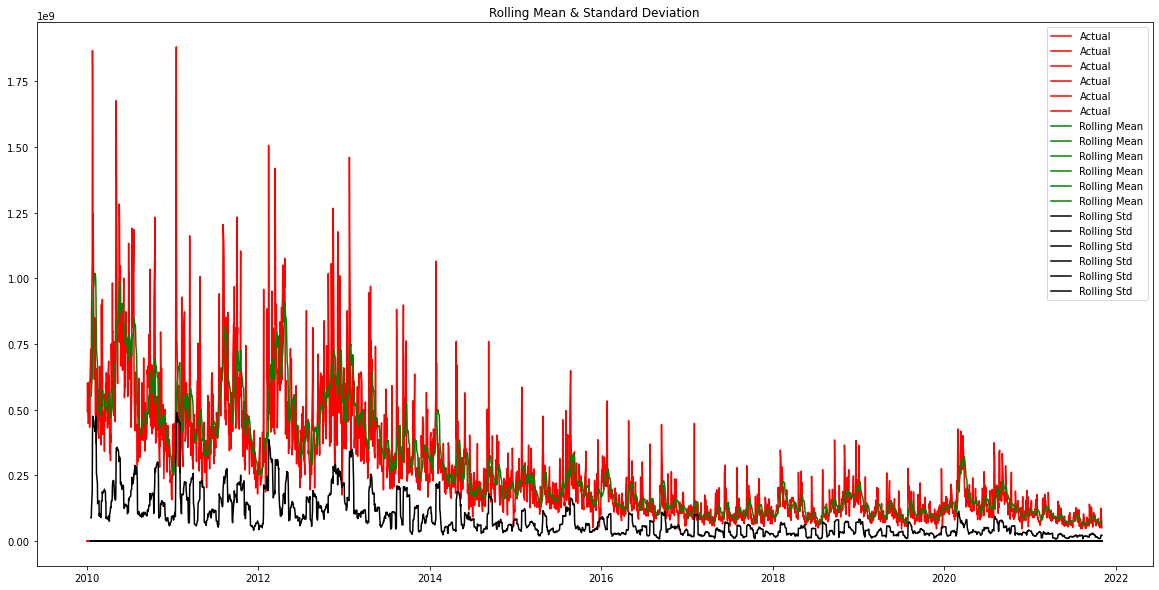

In [ ]:
plt.figure(figsize=(20,10))
actual=plt.plot(data, color='red', label='Actual')
mean_6=plt.plot(rolmean, color='green', label='Rolling Mean') 
std_6=plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

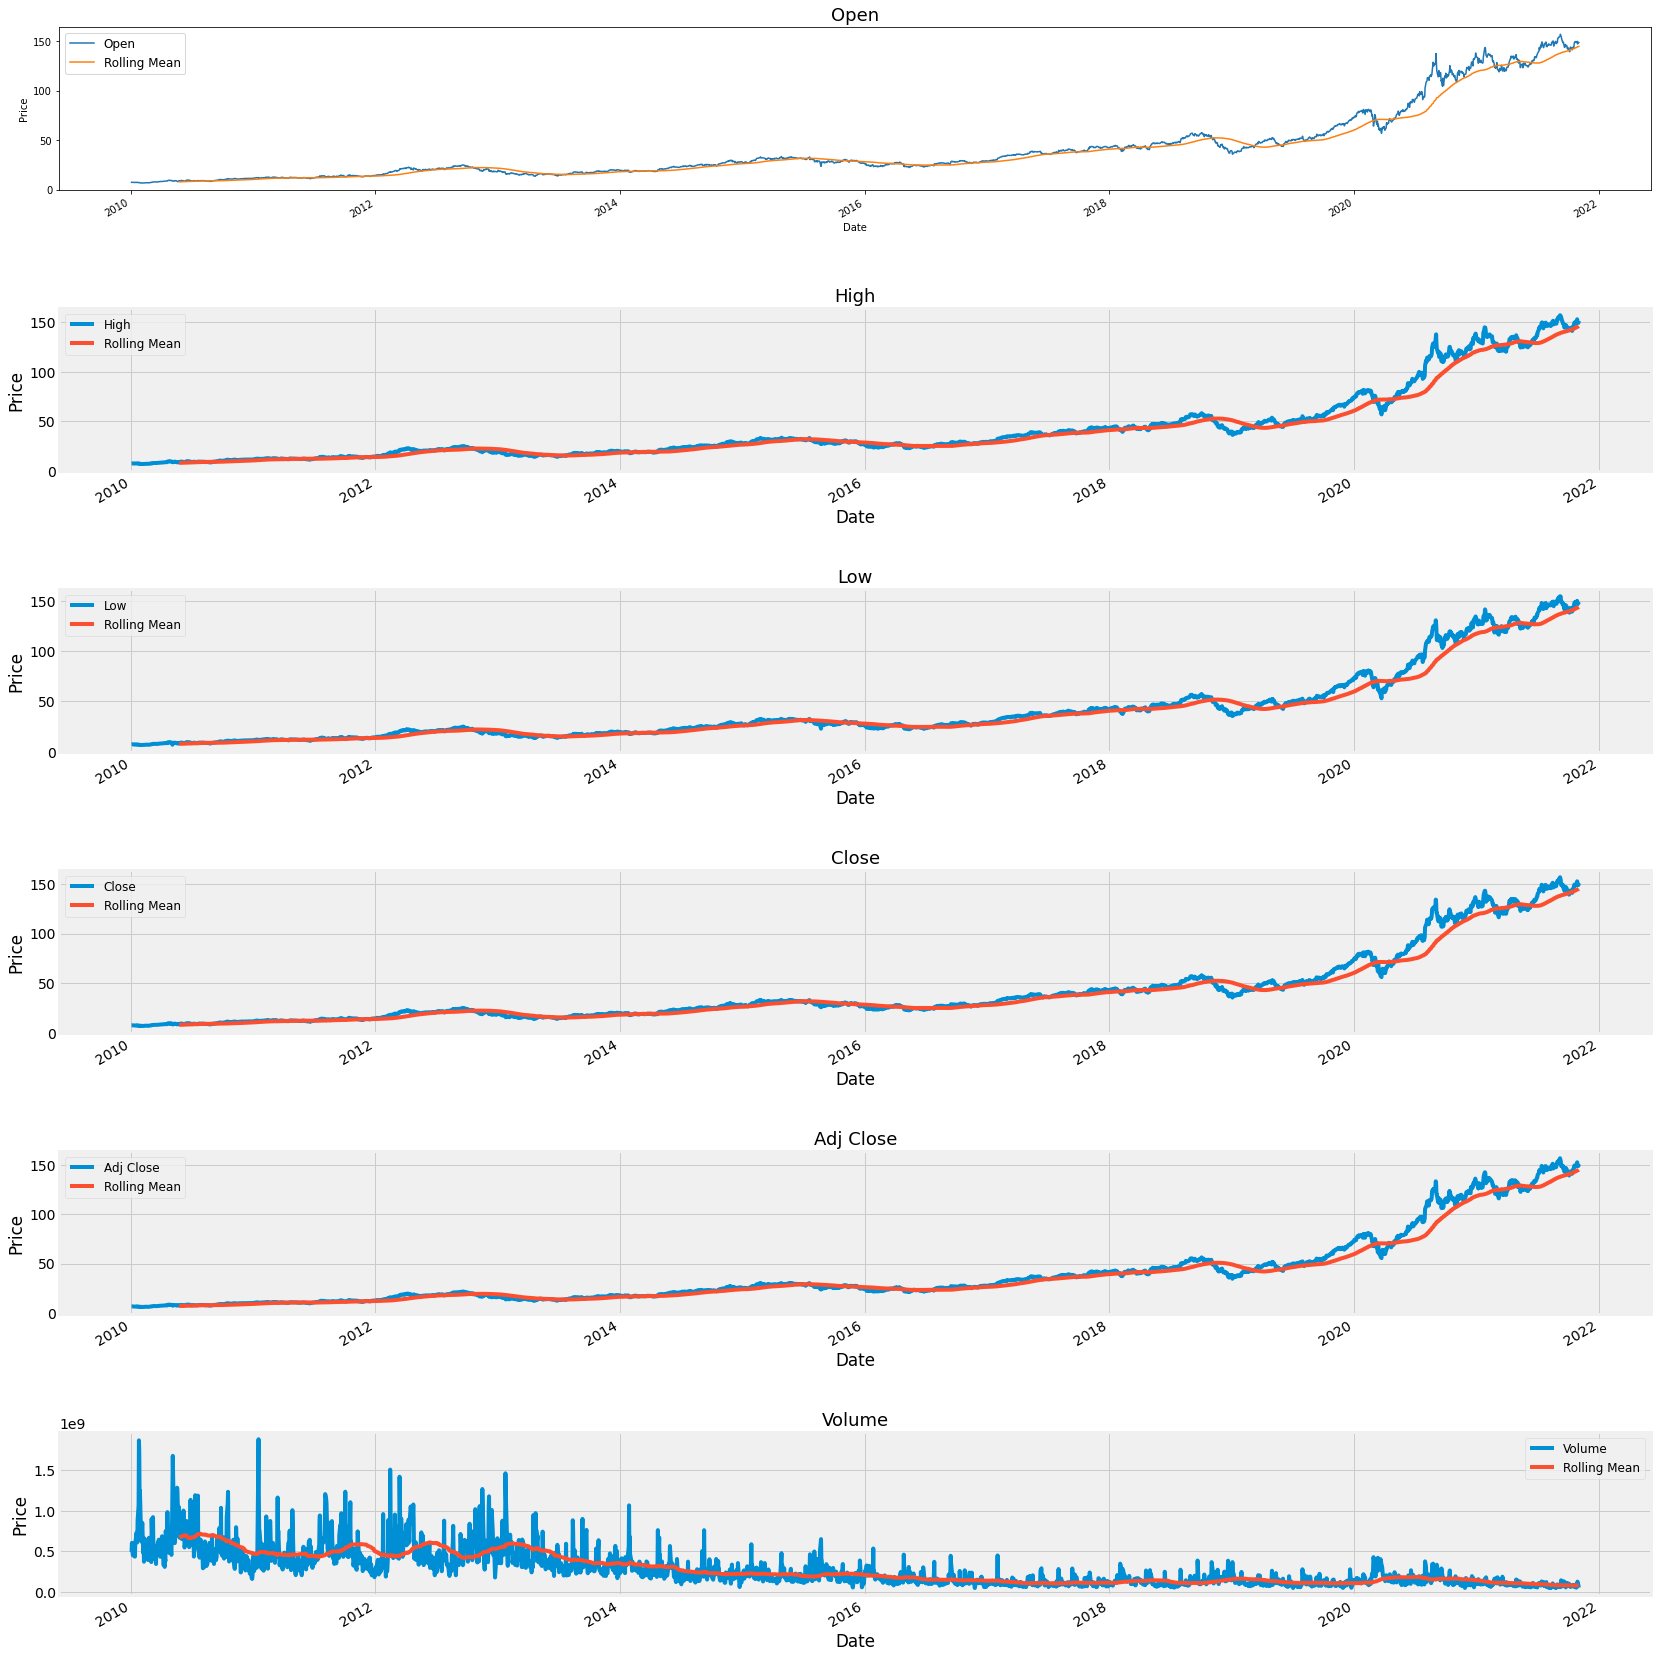

In [ ]:
col_names = data.columns

fig = plt.figure(figsize=(24, 24))
for i in range(6):
  ax = fig.add_subplot(6,1,i+1)
  ax.plot(data.iloc[:,i],label=col_names[i])
  data.iloc[:,i].rolling(100).mean().plot(label='Rolling Mean')
  ax.set_title(col_names[i],fontsize=18)
  ax.set_xlabel('Date')
  ax.set_ylabel('Price')
  ax.patch.set_edgecolor('black')  
  plt.style.context('fivethirtyeight')
  plt.legend(prop={'size': 12})
  plt.style.use('fivethirtyeight')

fig.tight_layout(pad=3.0)

plt.show()

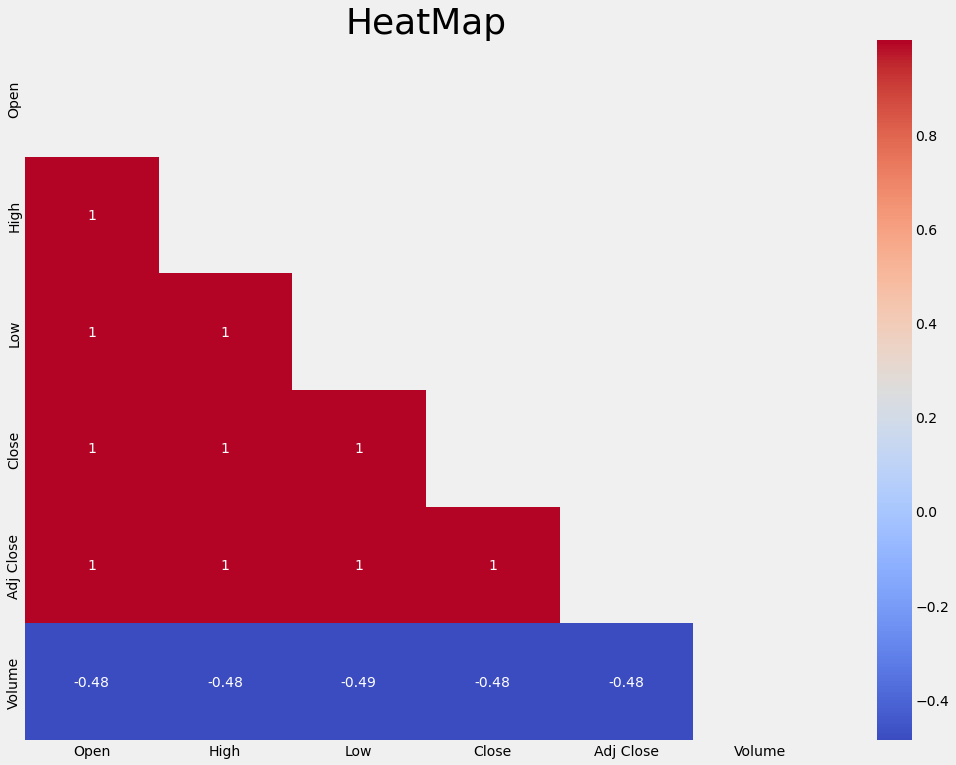

In [ ]:
##HeatMap to Verify Multicollinearity between Features
fig = plt.figure(figsize=(16,12))
matrix = np.triu(data.corr())
ax = sns.heatmap(data.corr(),annot=True,annot_kws={"size":14},mask=matrix,cmap='coolwarm')
ax.tick_params(labelsize=14)
sns.set(font_scale=3)
ax.set_title('HeatMap')
plt.style.use('fivethirtyeight')
plt.show()

In [ ]:
data_feature_selected = data.drop(axis=1,labels=['Open','High','Low','Close','Volume'])

In [ ]:
col_order = ['Adj Close']
data_feature_selected = data_feature_selected.reindex(columns=col_order)
data_feature_selected

Adj Close
Date                  
2010-01-04    6.562589
2010-01-05    6.573936
2010-01-06    6.469368
2010-01-07    6.457407
2010-01-08    6.500340
...                ...
2021-10-27  148.850006
2021-10-28  152.570007
2021-10-29  149.800003
2021-11-01  148.960007
2021-11-02  150.580002

[2980 rows x 1 columns]

In [ ]:
##Resample Data to Monthly instead of Daily by Aggregating Using Mean
monthly_mean = data_feature_selected['Adj Close'].resample('M').mean()

In [ ]:
monthly_data = monthly_mean.to_frame()
monthly_data

Adj Close
Date                  
2010-01-31    6.369562
2010-02-28    6.096047
2010-03-31    6.850866
2010-04-30    7.701438
2010-05-31    7.711035
...                ...
2021-07-31  144.922394
2021-08-31  148.137819
2021-09-30  148.306190
2021-10-31  145.563809
2021-11-30  149.770005

[143 rows x 1 columns]

In [ ]:
monthly_data['Year'] = monthly_data.index.year
monthly_data['Month'] = monthly_data.index.strftime('%B')
monthly_data['dayofweek'] = monthly_data.index.strftime('%A')
monthly_data['quarter'] = monthly_data.index.quarter
monthly_data

Adj Close  Year      Month  dayofweek  quarter
Date                                                       
2010-01-31    6.369562  2010    January     Sunday        1
2010-02-28    6.096047  2010   February     Sunday        1
2010-03-31    6.850866  2010      March  Wednesday        1
2010-04-30    7.701438  2010      April     Friday        2
2010-05-31    7.711035  2010        May     Monday        2
...                ...   ...        ...        ...      ...
2021-07-31  144.922394  2021       July   Saturday        3
2021-08-31  148.137819  2021     August    Tuesday        3
2021-09-30  148.306190  2021  September   Thursday        3
2021-10-31  145.563809  2021    October     Sunday        4
2021-11-30  149.770005  2021   November    Tuesday        4

[143 rows x 5 columns]

In [ ]:
from sklearn.model_selection import train_test_split as split
import itertools
warnings.filterwarnings("ignore")
from IPython import display
from matplotlib import pyplot
import os
import re
#from colorama import Fore, Back, Style
import seaborn as sns
import plotly.express as px
import warnings
from matplotlib.patches import Patch

(array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 ]),
 <a list of 7 Text major ticklabel objects>)

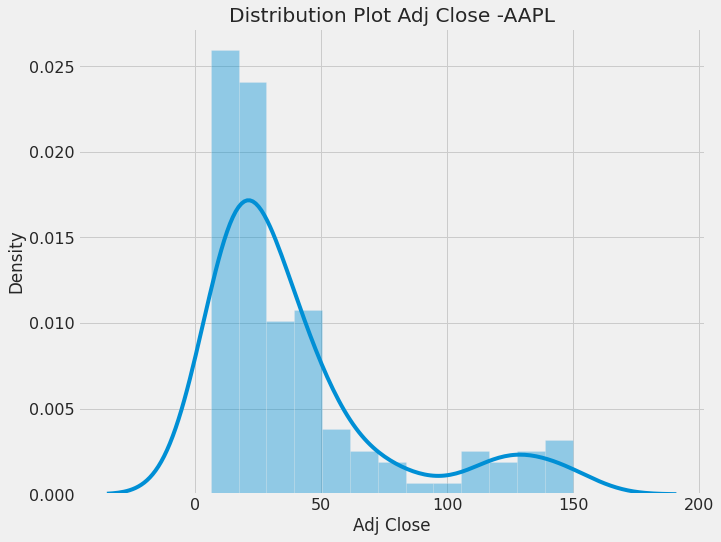

In [ ]:
fig = plt.figure(figsize=(10,8))
sns.distplot(monthly_data['Adj Close']).set_title("Distribution Plot Adj Close -AAPL")
#ax.tick_params(labelsize=12)
sns.set(font_scale=1)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

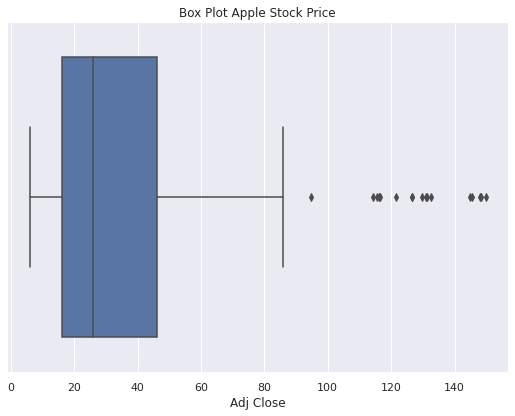

In [ ]:
fig = plt.figure(figsize=(8,6))
sns.boxplot(monthly_data['Adj Close']).set_title('Box Plot Apple Stock Price')
plt.style.context('fivethirtyeight')

Text(0.5, 1.0, 'QQ Plot Apple Stock Price')

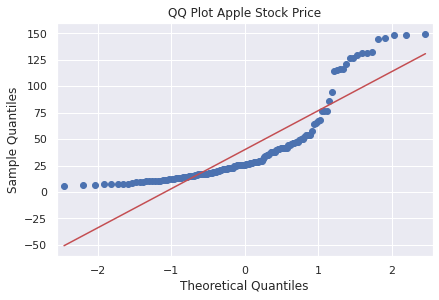

In [ ]:
qq_plot = qq(monthly_data['Adj Close'],line='s')
plt.title('QQ Plot Apple Stock Price')

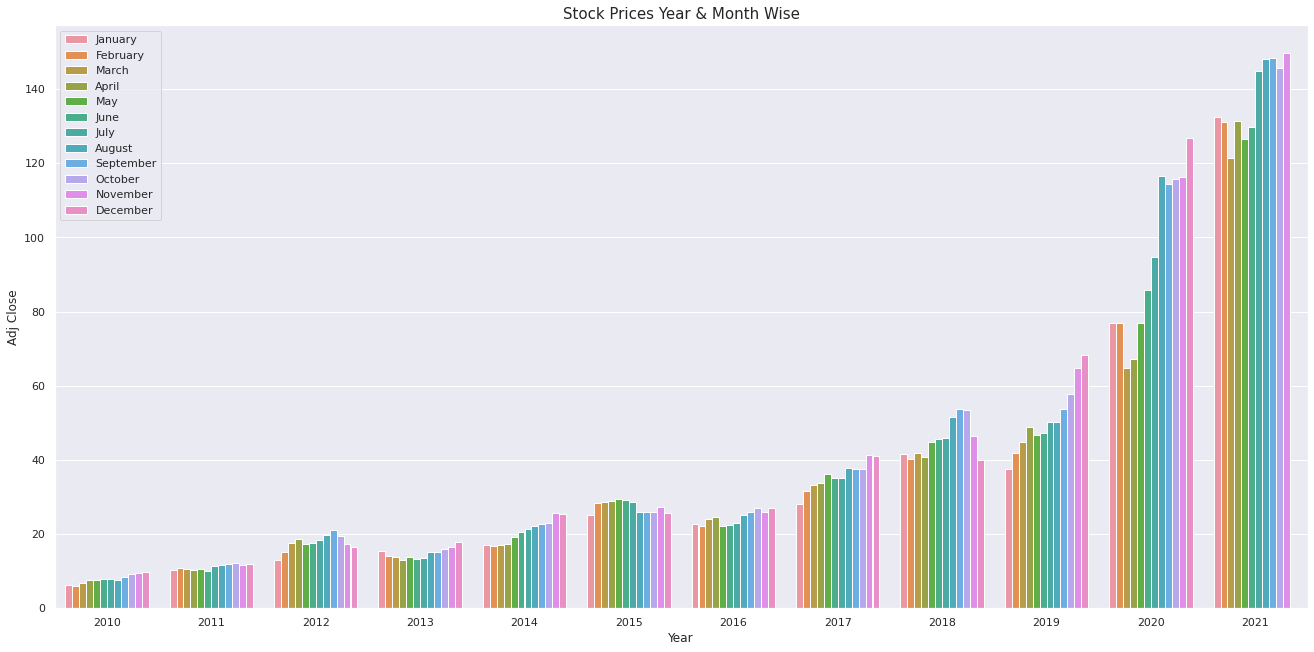

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
palette = sns.color_palette("mako_r", 4)
a = sns.barplot(x="Year", y="Adj Close",hue = 'Month',data=monthly_data)
a.set_title("Stock Prices Year & Month Wise",fontsize=15)
plt.legend(loc='upper left')
plt.show()

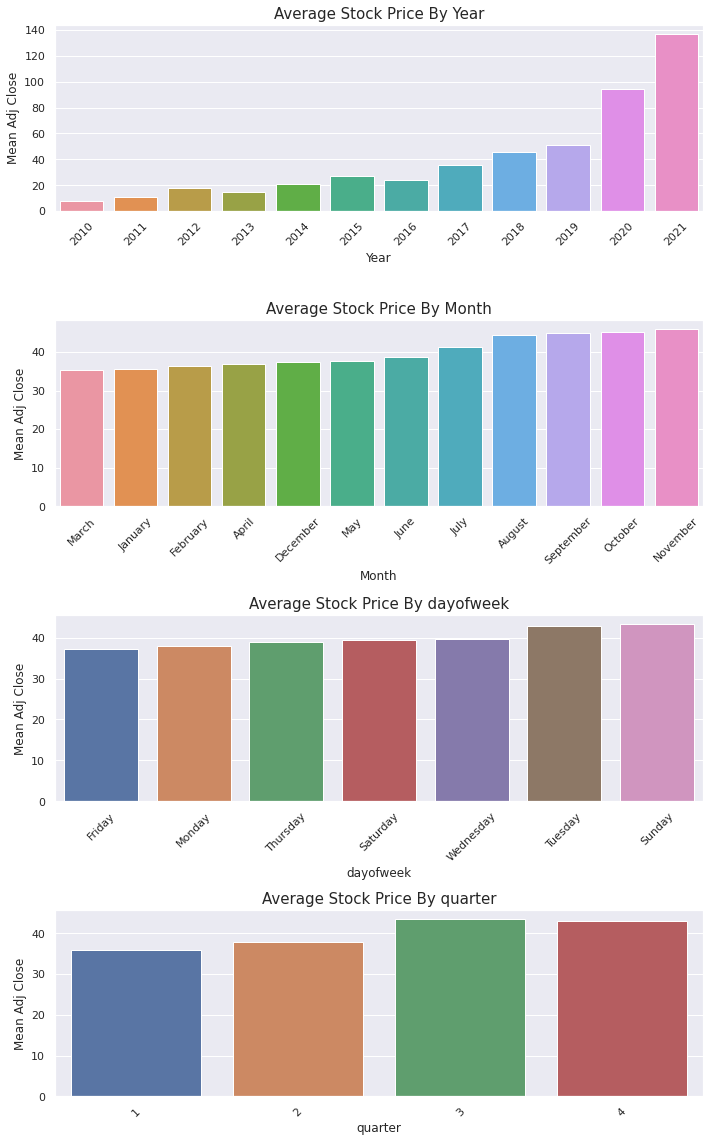

In [ ]:
fig = plt.figure(figsize=(10,16))
fig.set_size_inches(10,16)
group_cols = monthly_data.columns

for enum,i in enumerate(group_cols[1:]):
  ax = fig.add_subplot(4,1,enum+1)
  Aggregated = pd.DataFrame(monthly_data.groupby(str(i))["Adj Close"].mean()).reset_index().sort_values('Adj Close')
  sns.barplot(data=Aggregated,x=str(i),y="Adj Close",ax=ax)
  ax.set(xlabel=str(i), ylabel='Mean Adj Close')
  ax.set_title("Average Stock Price By {}".format(str(i)),fontsize=15)
  plt.xticks(rotation=45)
  
plt.tight_layout(pad=1)

<Figure size 1440x1152 with 0 Axes>

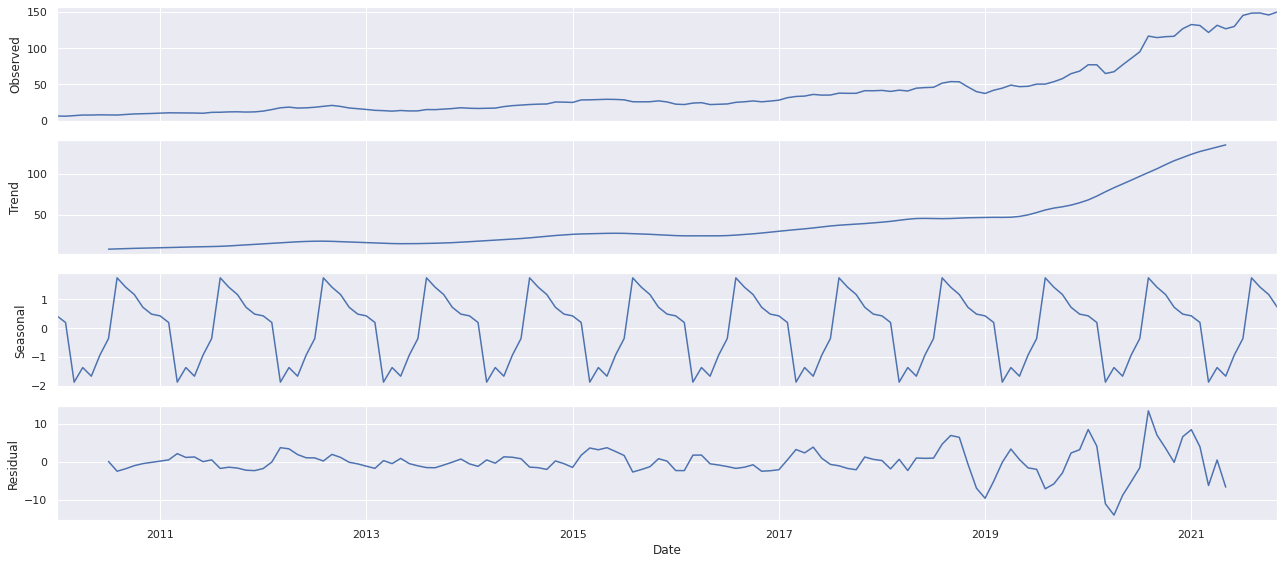

In [ ]:
rcParams['figure.figsize'] = 18, 8
plt.figure(figsize=(20,16))
decomposed_series = sd(monthly_data['Adj Close'],model='additive',freq=12)
decomposed_series.plot()
plt.show()

In [ ]:
##ADF Test-Statsmodels Library

def ad_fuller_func(X):
  result_ad_fuller = adfuller(X)
  print('ADF Statistic: %f' % result_ad_fuller[0])
  print('p-value: %f' %result_ad_fuller[1])
  print('Critical Values:')
  for key, value in result_ad_fuller[4].items():
	  print('\t%s: %.3f' % (key, value))
 
  if result_ad_fuller[0] < result_ad_fuller[4]['5%']:
    print('Reject Null Hypothesis(Ho)-Time Series is Stationary')
  else:
    print('Failed to Reject Ho-Time Series is Non-Stationary')

In [ ]:
ad_fuller_func(monthly_data['Adj Close'])

ADF Statistic: 1.739073
p-value: 0.998220
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579
Failed to Reject Ho-Time Series is Non-Stationary


Time Series is Not Stationary as observed earlier also by Decomposition(Trend and Seasonality Present)


Text(0.5, 0, 'Lags')

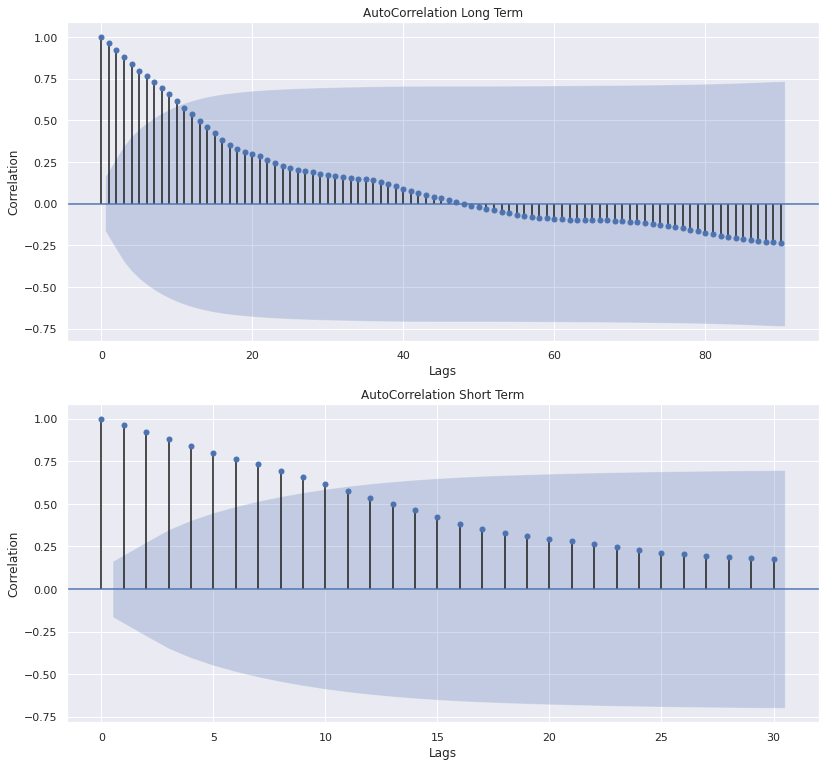

In [ ]:
fig,(ax1,ax2) = plt.subplots(2,figsize=(12,12))
acf = plot_acf(monthly_data['Adj Close'],lags=90,ax=ax1)
ax1.set_title('AutoCorrelation Long Term')
acf = plot_acf(monthly_data['Adj Close'],lags=30,ax=ax2)
ax2.set_title('AutoCorrelation Short Term')    # auto correction
ax1.set_ylabel('Correlation')
ax1.set_xlabel('Lags')
ax2.set_ylabel('Correlation')
ax2.set_xlabel('Lags')

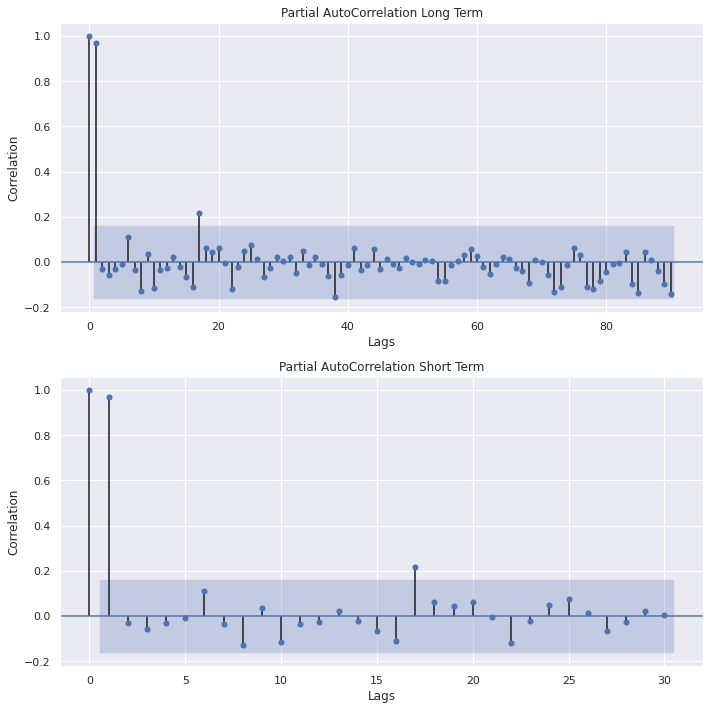

In [ ]:
fig,(ax1,ax2) = plt.subplots(2,figsize=(10,10))
pacf = plot_pacf(monthly_data['Adj Close'],lags=90,ax=ax1)
ax1.set_title('Partial AutoCorrelation Long Term')
pacf = plot_pacf(monthly_data['Adj Close'],lags=30,ax=ax2)
ax2.set_title('Partial AutoCorrelation Short Term')
ax1.set_ylabel('Correlation')
ax1.set_xlabel('Lags')
ax2.set_ylabel('Correlation')
ax2.set_xlabel('Lags')
plt.tight_layout(pad=1)

In [ ]:
##Differencing By 1. To make it stationary
monthly_data['monthly_diff'] = monthly_data['Adj Close'] - monthly_data['Adj Close'].shift(1)

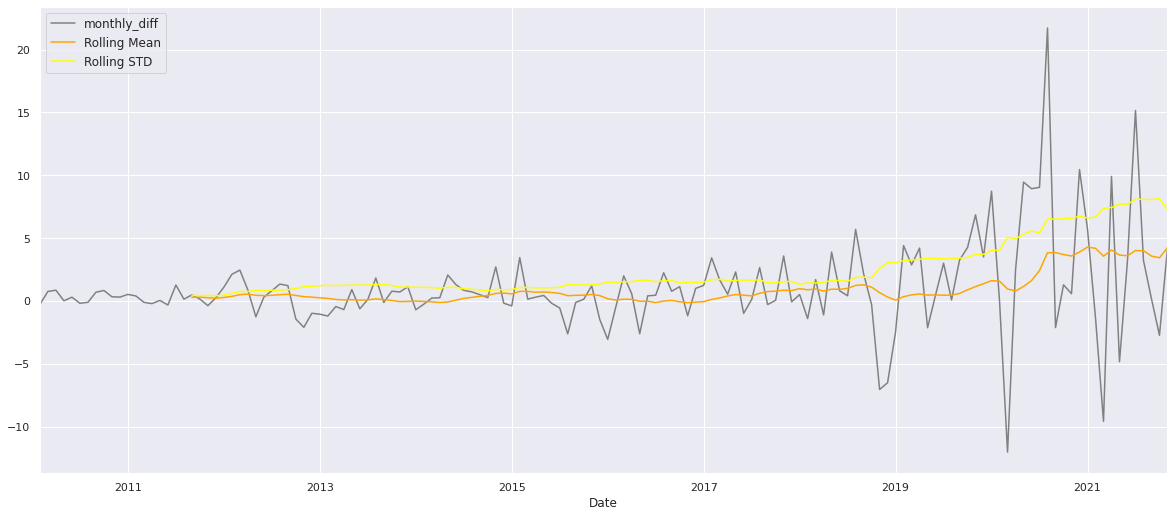

In [ ]:
monthly_data['monthly_diff'][1:].plot(c='grey')
monthly_data['monthly_diff'][1:].rolling(20).mean().plot(label='Rolling Mean',c='orange')
monthly_data['monthly_diff'][1:].rolling(20).std().plot(label='Rolling STD',c='yellow')
plt.legend(prop={'size': 12})

In [ ]:
##Checking if Time Series is Stationary by Running ADF Test
ad_fuller_func(monthly_data['monthly_diff'][1:])

ADF Statistic: -1.856669
p-value: 0.352712
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579
Failed to Reject Ho-Time Series is Non-Stationary


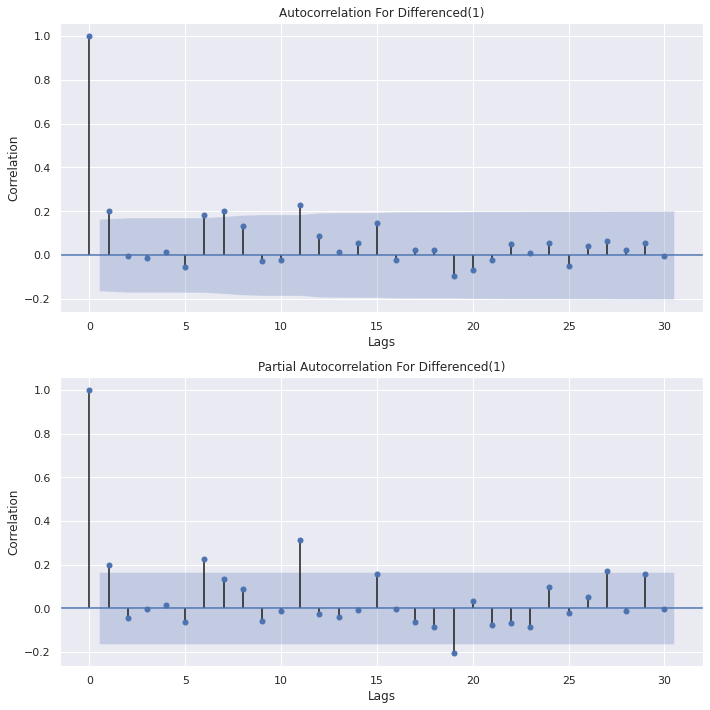

In [ ]:
fig,(ax1,ax2) = plt.subplots(2,figsize=(10,10))
acf = plot_acf(monthly_data['monthly_diff'][1:],lags=30,ax=ax1)
pacf = plot_pacf(monthly_data['monthly_diff'][1:],lags=30,ax=ax2)
ax1.set_title('Autocorrelation For Differenced(1)')
ax1.set_ylabel('Correlation')
ax1.set_xlabel('Lags')
ax2.set_title('Partial Autocorrelation For Differenced(1)')
ax2.set_ylabel('Correlation')
ax2.set_xlabel('Lags')
plt.tight_layout(pad=1)

In [ ]:
from statsmodels.tsa.stattools import kpss

In [ ]:
# KPSS test
from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(monthly_data['monthly_diff'][1:])

KPSS Statistic: 0.528477963970444
p-value: 0.035252710817467565
num lags: 14
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


In [ ]:
# KPSS test
from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(monthly_data['monthly_diff'][1:])

KPSS Statistic: 0.528477963970444
p-value: 0.035252710817467565
num lags: 14
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


In [ ]:
from scipy import stats
from scipy.special import inv_boxcox
from typing import Tuple
import lightgbm as lgb
from datetime import timedelta

# Transform to make stationary 

In [ ]:
# Define power trnnsformations and their inverses
# Square root transformation
def square_root_transformation(x: pd.Series) -> pd.Series:
    return np.sqrt(x)

def square_root_inverse_transformation(x: pd.Series) -> pd.Series:
    return np.square(x)

# Cube root transformation
def cube_root_transformation(x: pd.Series) -> pd.Series:
    return x ** (1 / 3)

def cube_root_inverse_transformation(x: pd.Series) -> pd.Series:
    return x ** 3

# Log transformation
def log_transformation(x: pd.Series) -> pd.Series:
    # Function np.log1p = log(x + 1)
    return np.log1p(x)

def log_inverse_transformation(x: pd.Series) -> pd.Series:
    # Function np.expm1(x) = exp(x) - 1
    return np.expm1(x)

# Box-cox transformation
def box_cox_transformation(x: pd.Series) -> Tuple[np.array, float]:
    x_transformed, lambda_value = stats.boxcox(x)
    return x_transformed, lambda_value
    
def box_cox_inverse_transformation(x: pd.Series, lambda_value: float) -> pd.Series:
    return inv_boxcox(x, lambda_value)

In [ ]:
monthly_data.reset_index(inplace=True)

In [ ]:
#data['square_root_inv_transformation_demand'] = data.groupby('id')['square_root_transformation_demand'].apply(lambda x: square_root_inverse_transformation(x))

In [ ]:
monthly_data['square_root_transformation_demand'] = monthly_data['Adj Close'].apply(lambda x: square_root_transformation(x))

# Apply the inverse square root transformation
monthly_data['square_root_inv_transformation_demand'] = monthly_data['square_root_transformation_demand'].apply(lambda x: square_root_inverse_transformation(x))

# Cube Root
monthly_data['cube_root_transformation_demand'] = monthly_data['Adj Close'].apply(lambda x: cube_root_transformation(x))

# Apply the inverse square root transformation
monthly_data['cube_root_inv_transformation_demand'] = monthly_data['cube_root_transformation_demand'].apply(lambda x: cube_root_inverse_transformation(x))

# Log Root
monthly_data['log_transformation_demand'] = monthly_data['Adj Close'].apply(lambda x: log_transformation(x))

# Apply the inverse square root transformation
monthly_data['log_inv_transformation_demand'] = monthly_data['log_transformation_demand'].apply(lambda x: log_inverse_transformation(x))






In [ ]:
monthly_data

Date  ...  log_inv_transformation_demand
0   2010-01-31  ...                       6.369562
1   2010-02-28  ...                       6.096047
2   2010-03-31  ...                       6.850866
3   2010-04-30  ...                       7.701438
4   2010-05-31  ...                       7.711035
..         ...  ...                            ...
138 2021-07-31  ...                     144.922394
139 2021-08-31  ...                     148.137819
140 2021-09-30  ...                     148.306190
141 2021-10-31  ...                     145.563809
142 2021-11-30  ...                     149.770004

[143 rows x 13 columns]

In [ ]:
FIGURE_SIZE = (20, 10)
plt.rcParams['axes.grid'] = True

%matplotlib inline

In [ ]:
def plot_transformations(df: pd.DataFrame, transformation: str) -> None:
    # Get axes for multiple plots
    fig, axes = plt.subplots(nrows=1, ncols=3)
    
    # Original data
    monthly_data.set_index('Date')['Adj Close'].plot(figsize=FIGURE_SIZE, ax=axes[0], color='blue')
    
    # Transformed data
    transformed_column_name = f'{transformation}_transformation_demand'
    monthly_data.set_index('Date')[transformed_column_name].plot(figsize=FIGURE_SIZE, ax=axes[1], color='red')
    
    # Inverse Transformed data
    inverse_transformed_data = f'{transformation}_inv_transformation_demand'
    monthly_data.set_index('Date')[inverse_transformed_data].plot(figsize=FIGURE_SIZE, ax=axes[2], color='orange')

In [ ]:
#monthly_data.reset_index(inplace=True) # if plot did not show reset index

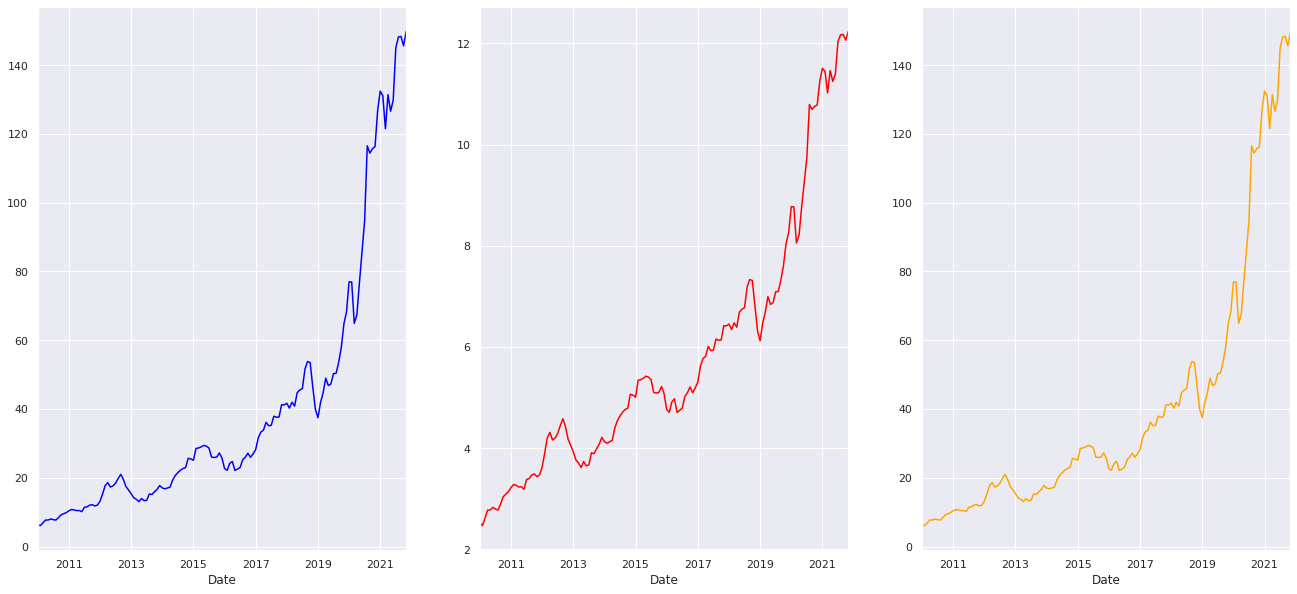

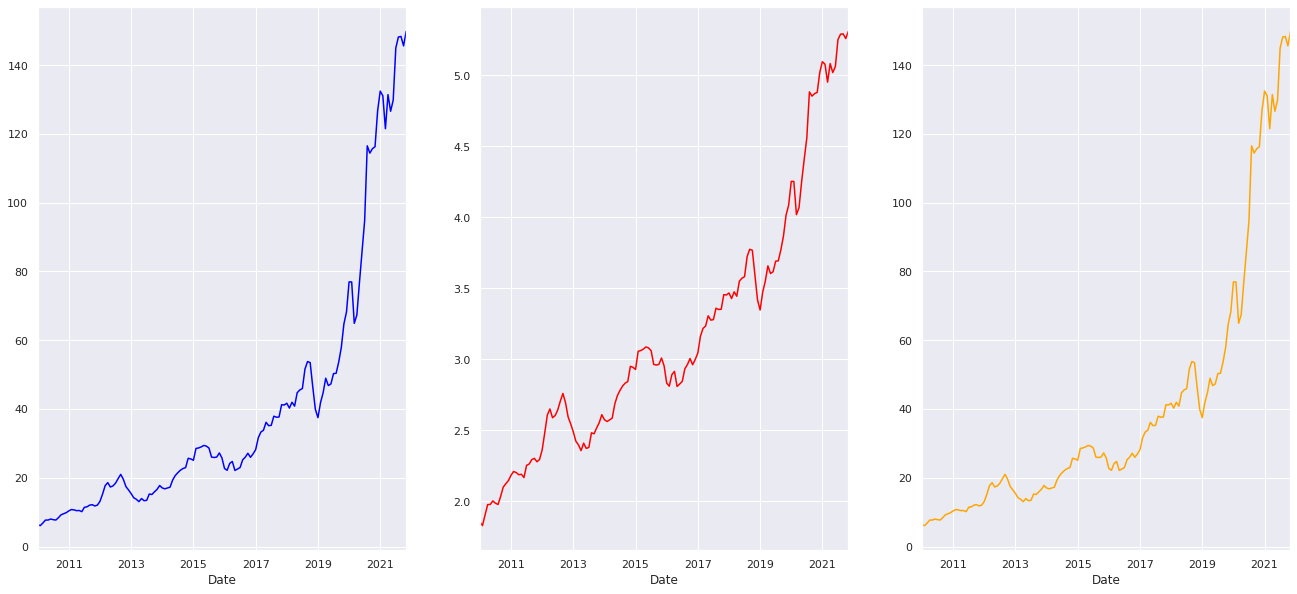

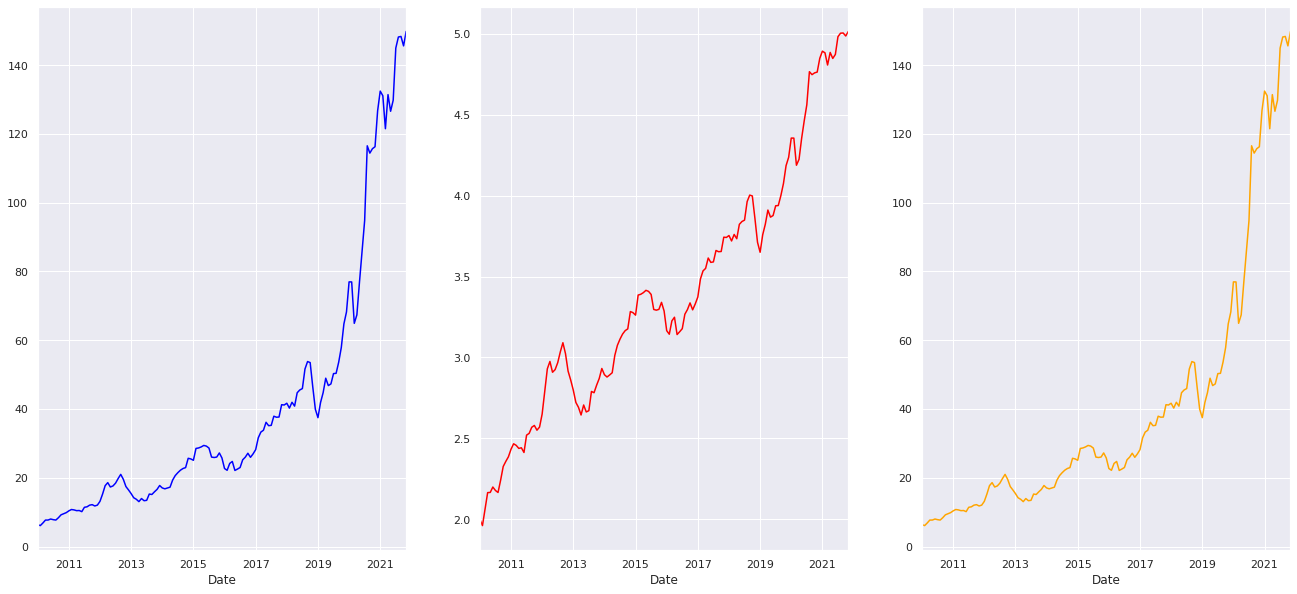

In [ ]:
plot_transformations(monthly_data,'square_root') #  square_root log
plot_transformations(monthly_data, 'cube_root')
plot_transformations(monthly_data, 'log')



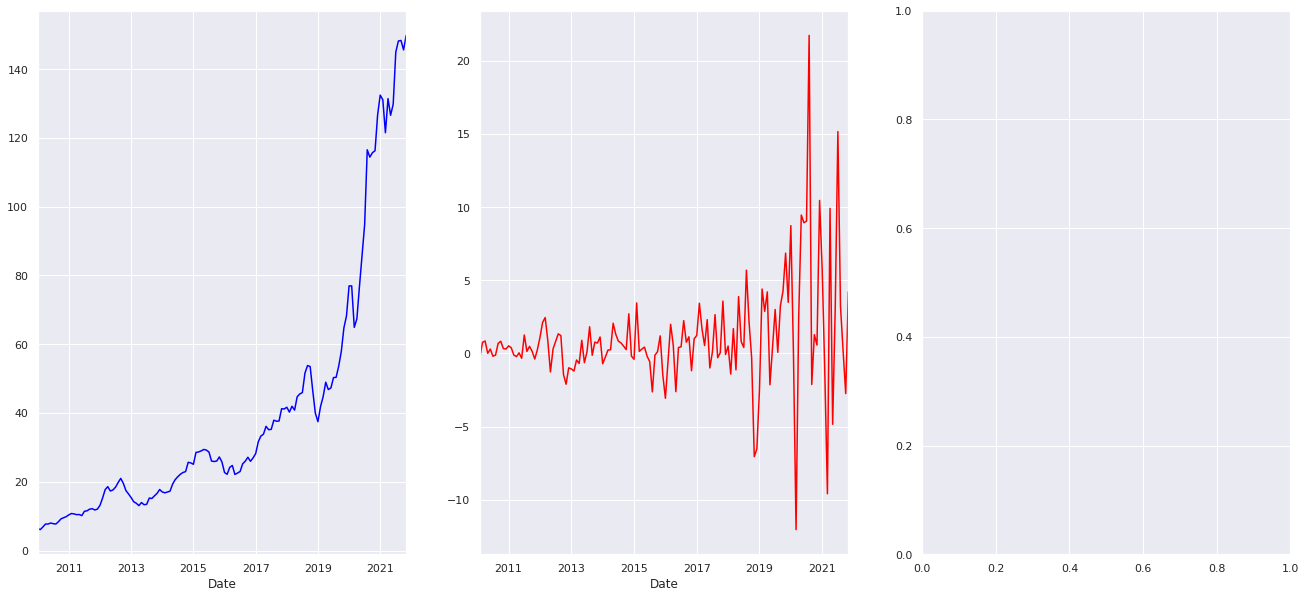

In [ ]:
# Get axes for multiple plots
fig, axes = plt.subplots(nrows=1, ncols=3)
    
    # Original data
monthly_data.set_index('Date')['Adj Close'].plot(figsize=FIGURE_SIZE, ax=axes[0], color='blue')
    
    # Transformed data
transformed_column_name = 'monthly_diff'
monthly_data.set_index('Date')[transformed_column_name][1:].plot(figsize=FIGURE_SIZE, ax=axes[1], color='red')
    
#     # Inverse Transformed data
# inverse_transformed_data = f'{transformation}_inv_transformation_demand'
#  monthly_data.set_index('Date')[inverse_transformed_data].plot(figsize=FIGURE_SIZE, ax=axes[2], color='orange')

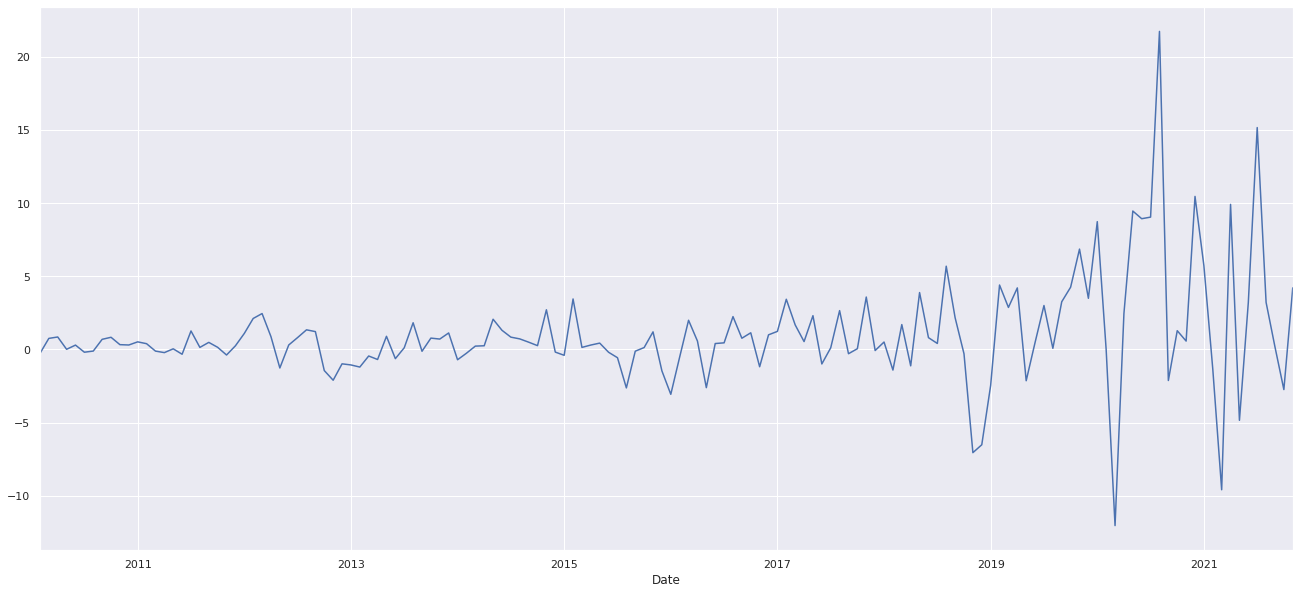

In [ ]:
monthly_data.set_index('Date')['monthly_diff'][1:].plot(figsize=FIGURE_SIZE)

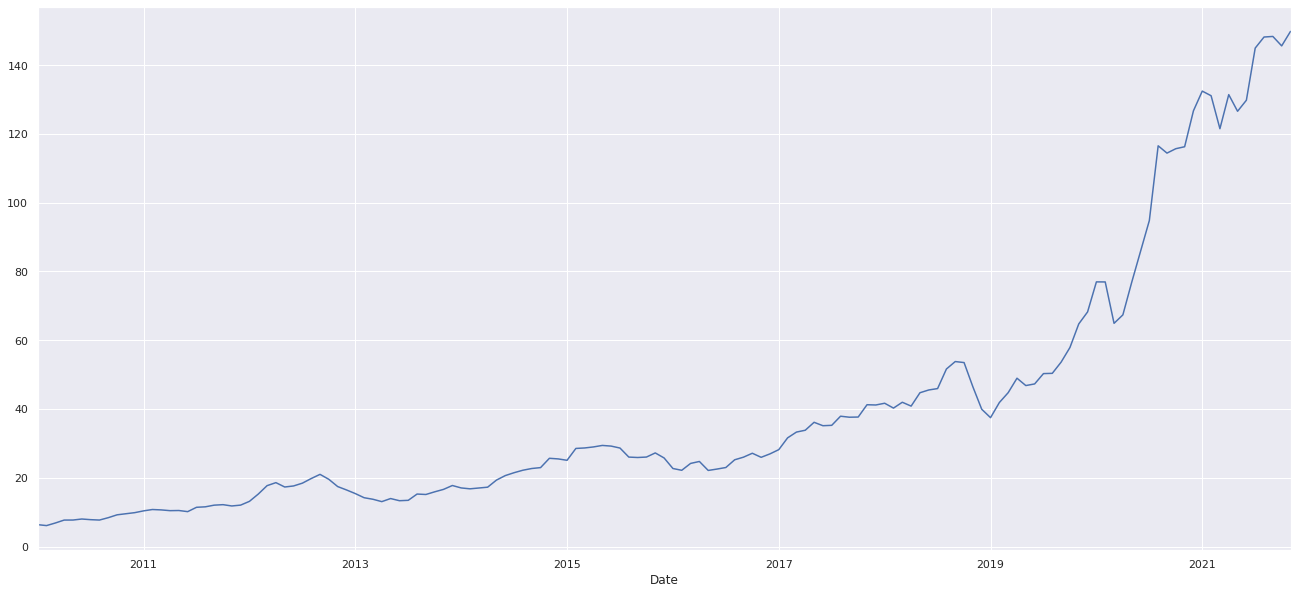

In [ ]:
monthly_data.set_index('Date')['Adj Close'].plot(figsize=FIGURE_SIZE)

In [ ]:
monthly_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 13 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   Date                                   143 non-null    datetime64[ns]
 1   Adj Close                              143 non-null    float64       
 2   Year                                   143 non-null    int64         
 3   Month                                  143 non-null    object        
 4   dayofweek                              143 non-null    object        
 5   quarter                                143 non-null    int64         
 6   monthly_diff                           142 non-null    float64       
 7   square_root_transformation_demand      143 non-null    float64       
 8   square_root_inv_transformation_demand  143 non-null    float64       
 9   cube_root_transformation_demand        143 non-null    float64   

In [ ]:
# KPSS test
from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(monthly_data['monthly_diff'][1:])

KPSS Statistic: 0.528477963970444
p-value: 0.035252710817467565
num lags: 14
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


In [ ]:
kpss_test(monthly_data['log_transformation_demand'])
print(" ***  ")
print(" ***  ")
kpss_test(monthly_data['cube_root_transformation_demand'])
print(" ***  ")
print(" ***  ")
kpss_test(monthly_data['square_root_transformation_demand'])


KPSS Statistic: 1.0234809821378617
p-value: 0.01
num lags: 14
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary
 ***  
 ***  
KPSS Statistic: 0.9793176648560024
p-value: 0.01
num lags: 14
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary
 ***  
 ***  
KPSS Statistic: 0.9463550967388723
p-value: 0.01
num lags: 14
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


In [ ]:
def stationarity(timeseries):
    
    rolmean=timeseries.rolling(window=12).mean()
    rolstd=timeseries.rolling(window=12).std()
    
    plt.figure(figsize=(20,10))
    actual=plt.plot(timeseries, color='red', label='Actual')
    mean_6=plt.plot(rolmean, color='green', label='Rolling Mean') 
    std_6=plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    print('Dickey-Fuller Test: ')
    dftest=adfuller(timeseries[1:], autolag='AIC') #BIC
    dfoutput=pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Obs'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

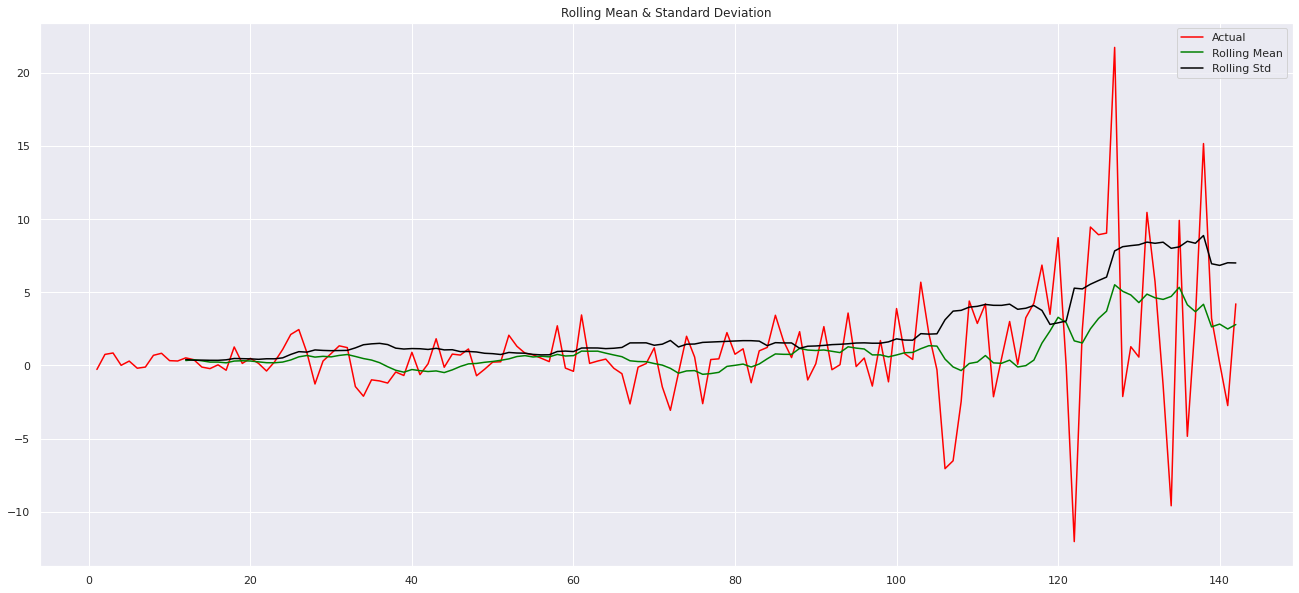

Dickey-Fuller Test: 
Test Statistic           -1.851527
p-value                   0.355196
Lags Used                11.000000
No. of Obs              129.000000
Critical Value (1%)      -3.482088
Critical Value (5%)      -2.884219
Critical Value (10%)     -2.578864
dtype: float64


In [ ]:
stationarity(monthly_data['monthly_diff'][1:])

In [ ]:
monthly_data['differenced_trasnformation_demand'] = monthly_data['Adj Close'].diff().values
monthly_data.head()

Date  ...  differenced_trasnformation_demand
0 2010-01-31  ...                                NaN
1 2010-02-28  ...                          -0.273515
2 2010-03-31  ...                           0.754818
3 2010-04-30  ...                           0.850573
4 2010-05-31  ...                           0.009596

[5 rows x 14 columns]

In [ ]:
monthly_data['differenced_demand_filled'] = np.where(pd.isnull(monthly_data['differenced_trasnformation_demand']), monthly_data['Adj Close'], monthly_data['differenced_trasnformation_demand'])
monthly_data.head()

Date  ...  differenced_demand_filled
0 2010-01-31  ...                   6.369562
1 2010-02-28  ...                  -0.273515
2 2010-03-31  ...                   0.754818
3 2010-04-30  ...                   0.850573
4 2010-05-31  ...                   0.009596

[5 rows x 15 columns]

In [ ]:
monthly_data['differenced_inv_transformation_demand'] = monthly_data['differenced_demand_filled'].cumsum()
np.testing.assert_array_equal(monthly_data['Adj Close'].values, monthly_data['differenced_inv_transformation_demand'].values)

In [ ]:
monthly_data.head()

Date  ...  differenced_inv_transformation_demand
0 2010-01-31  ...                               6.369562
1 2010-02-28  ...                               6.096047
2 2010-03-31  ...                               6.850866
3 2010-04-30  ...                               7.701438
4 2010-05-31  ...                               7.711035

[5 rows x 16 columns]

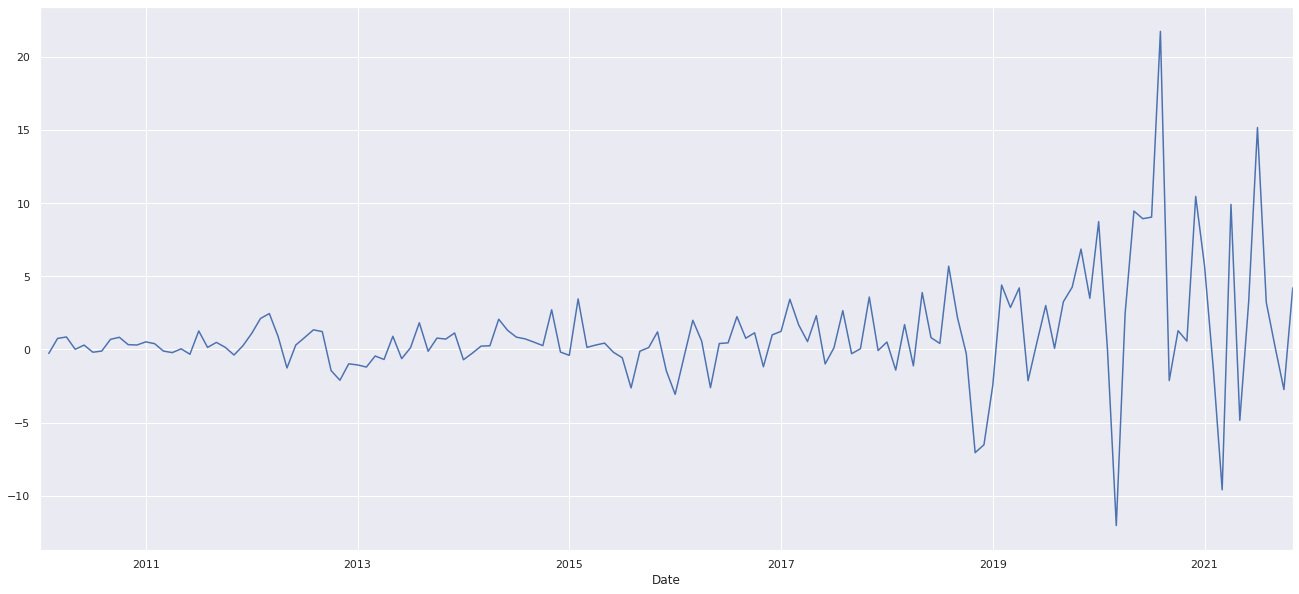

In [ ]:
monthly_data.set_index('Date')['differenced_trasnformation_demand'].plot(figsize=FIGURE_SIZE)

In [ ]:
def build_temporal_features(data: pd.DataFrame) -> pd.DataFrame:
    # Temporal features
    #monthly_data['date'] = pd.to_datetime(data['date'])
    #data['year'] = data['date'].dt.year
    #data['month'] = data['date'].dt.month
    monthly_data['week'] = monthly_data['Date'].dt.week
    monthly_data['day'] = monthly_data['Date'].dt.day
    monthly_data['dayofweek'] = monthly_data['Date'].dt.dayofweek
    #data['quarter'] = data['date'].dt.quarter
    #data['week_of_month'] = data['day'].apply(lambda x: np.ceil(x / 7)).astype(np.int8)
    monthly_data['is_weekend'] = (monthly_data['dayofweek'] > 5).astype(np.int8)
    
    return monthly_data

In [ ]:
df1 = build_temporal_features(monthly_data)
df1.head()

Date  Adj Close  Year  ... week  day  is_weekend
0 2010-01-31   6.369562  2010  ...    4   31           1
1 2010-02-28   6.096047  2010  ...    8   28           1
2 2010-03-31   6.850866  2010  ...   13   31           0
3 2010-04-30   7.701438  2010  ...   17   30           0
4 2010-05-31   7.711035  2010  ...   22   31           0

[5 rows x 19 columns]

# select & split data to prepare for deep learning 

In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn.metrics as metrics
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
FIGURE_SIZE = (20, 10)
plt.rcParams['axes.grid'] = True

%matplotlib inline

In [5]:
import tensorflow as tf

 Set seed to get same results when re-run code of model

In [92]:
tf.random.set_seed(1234)

In [6]:
df11 = pd.read_csv("stock.csv")
df11.head()


Date  Adj Close  ...  week_of_month  is_weekend
0  2010-01-04   6.562589  ...              1           0
1  2010-01-05   6.573936  ...              1           0
2  2010-01-06   6.469368  ...              1           0
3  2010-01-07   6.457407  ...              1           0
4  2010-01-08   6.500340  ...              2           0

[5 rows x 13 columns]

In [ ]:
df11

Date   Adj Close  ...  week_of_month  is_weekend
0     2010-01-04    6.562589  ...              1           0
1     2010-01-05    6.573936  ...              1           0
2     2010-01-06    6.469368  ...              1           0
3     2010-01-07    6.457407  ...              1           0
4     2010-01-08    6.500340  ...              2           0
...          ...         ...  ...            ...         ...
2975  2021-10-27  148.850006  ...              4           0
2976  2021-10-28  152.570007  ...              4           0
2977  2021-10-29  149.800003  ...              5           0
2978  2021-11-01  148.960007  ...              1           0
2979  2021-11-02  150.580002  ...              1           0

[2980 rows x 13 columns]

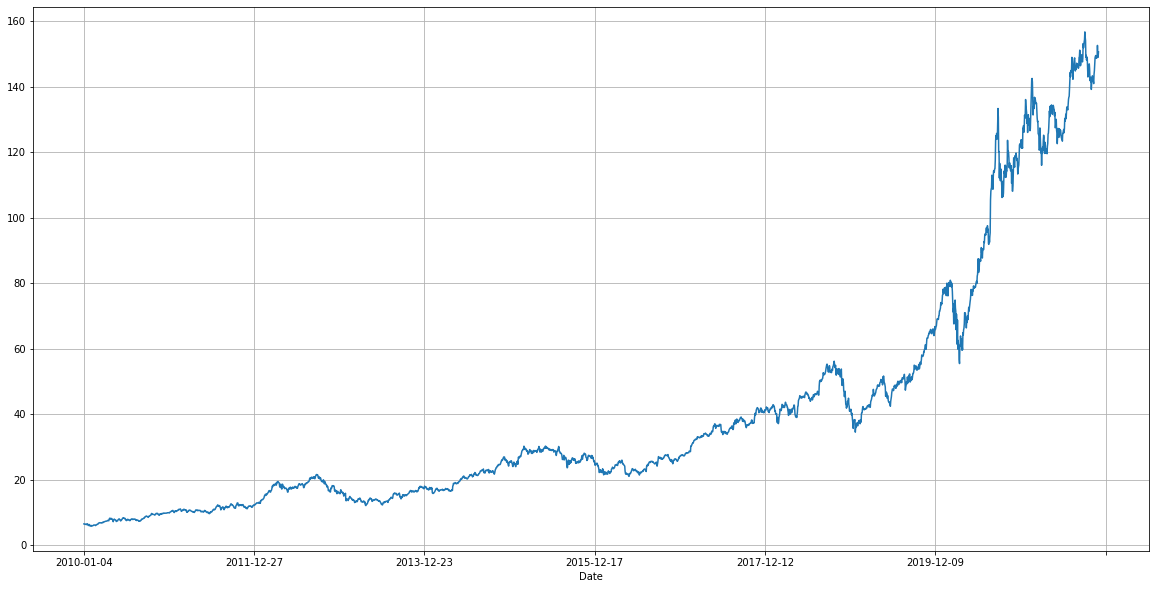

In [ ]:
df11.set_index('Date')['Adj Close'].plot(figsize=FIGURE_SIZE)

In [ ]:

mask = (df11['Date'] > '2010-01-01') & (df11['Date'] <= '2019-12-31')
print(df11.loc[mask])

            Date  Adj Close  ...  week_of_month  is_weekend
0     2010-01-04   6.562589  ...              1           0
1     2010-01-05   6.573936  ...              1           0
2     2010-01-06   6.469368  ...              1           0
3     2010-01-07   6.457407  ...              1           0
4     2010-01-08   6.500340  ...              2           0
...          ...        ...  ...            ...         ...
2511  2019-12-24  70.129509  ...              4           0
2512  2019-12-26  71.520905  ...              4           0
2513  2019-12-27  71.493767  ...              4           0
2514  2019-12-30  71.918076  ...              5           0
2515  2019-12-31  72.443565  ...              5           0

[2516 rows x 13 columns]


In [ ]:
df12=df11.loc[mask]

select your feature 

In [93]:
#X=  df11[['Date']]
y= df11['Adj Close']

# Scale and transform

In [94]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
y=scaler.fit_transform(np.array(y).reshape(-1,1))

In [95]:
##splitting dataset into train and test split
training_size=int(len(y)*0.65)
test_size=len(y)-training_size
train_data,test_data=y[0:training_size,:],y[training_size:len(y),:1]

In [96]:
training_size,test_size

(1937, 1043)

In [97]:
train_data[2]

array([0.00384731])

In [98]:
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]  #0-100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [99]:
import numpy

In [100]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [101]:
print(X_train.shape), print(y_train.shape)

(1836, 100)
(1836,)


(None, None)

In [102]:
print(X_test.shape), print(ytest.shape)

(942, 100)
(942,)


(None, None)

In [103]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [104]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout ,BatchNormalization
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.initializers import RandomNormal, Constant


# LSTM Model

In [105]:


# model=Sequential()
# model.add(LSTM(150,return_sequences=True,input_shape=(100,1)))
# model.add(Dropout(0.2))
# model.add(LSTM(150,return_sequences=True))
# model.add(LSTM(150, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(100))
# model.add(Dropout(0.2))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error',optimizer='adam')


model=Sequential()
# Adding first LSTM layer
model.add(LSTM(units=100, return_sequences=True, input_shape=(100,1)))
model.add(Dropout(0.2))
# second LSTM layer 
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))
# Adding third LSTM layer 
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))
# Adding fourth LSTM layer
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))
# Adding fifth LSTM layer a
model.add(LSTM(units=100))
model.add(Dropout(0.2))
# Adding the Output Layer
model.add(Dense(units=1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')





In [106]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_62 (LSTM)              (None, 100, 100)          40800     
                                                                 
 dropout_49 (Dropout)        (None, 100, 100)          0         
                                                                 
 lstm_63 (LSTM)              (None, 100, 100)          80400     
                                                                 
 dropout_50 (Dropout)        (None, 100, 100)          0         
                                                                 
 lstm_64 (LSTM)              (None, 100, 100)          80400     
                                                                 
 dropout_51 (Dropout)        (None, 100, 100)          0         
                                                                 
 lstm_65 (LSTM)              (None, 100, 100)        

In [86]:
#history= model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=54,batch_size=84,verbose=1)

Epoch 1/54
22/22 [==============================] - 36s 2s/step - loss: 7.6719e-05 - val_loss: 9.7872e-04
Epoch 2/54
22/22 [==============================] - 25s 1s/step - loss: 7.1939e-05 - val_loss: 0.0010
Epoch 3/54
22/22 [==============================] - 25s 1s/step - loss: 6.6602e-05 - val_loss: 9.5697e-04
Epoch 4/54
22/22 [==============================] - 26s 1s/step - loss: 6.8357e-05 - val_loss: 8.5420e-04
Epoch 5/54
22/22 [==============================] - 25s 1s/step - loss: 7.2846e-05 - val_loss: 9.3086e-04
Epoch 6/54
22/22 [==============================] - 25s 1s/step - loss: 7.0045e-05 - val_loss: 8.3398e-04
Epoch 7/54
22/22 [==============================] - 25s 1s/step - loss: 7.2586e-05 - val_loss: 9.7613e-04
Epoch 8/54
22/22 [==============================] - 25s 1s/step - loss: 6.9511e-05 - val_loss: 0.0025
Epoch 9/54
22/22 [==============================] - 27s 1s/step - loss: 7.4774e-05 - val_loss: 8.8019e-04
Epoch 10/54
22/22 [==============================] - 2

In [107]:
from tensorflow.keras.callbacks import EarlyStopping

In [108]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, 
        verbose=1, mode='auto', restore_best_weights=True)

history=model.fit(X_train,y_train,validation_data=(X_test,ytest),
        callbacks=[monitor],verbose=1,epochs=1000)

Epoch 1/1000
58/58 [==============================] - 62s 564ms/step - loss: 0.0014 - val_loss: 0.0077
Epoch 2/1000
58/58 [==============================] - 30s 525ms/step - loss: 1.5463e-04 - val_loss: 0.0019
Epoch 3/1000
58/58 [==============================] - 30s 519ms/step - loss: 1.1932e-04 - val_loss: 0.0021
Epoch 4/1000
58/58 [==============================] - 30s 513ms/step - loss: 1.0929e-04 - val_loss: 0.0020
Epoch 5/1000
58/58 [==============================] - 30s 524ms/step - loss: 1.0806e-04 - val_loss: 0.0016
Epoch 6/1000
58/58 [==============================] - 30s 512ms/step - loss: 9.5133e-05 - val_loss: 0.0022
Epoch 7/1000
58/58 [==============================] - 30s 518ms/step - loss: 7.7988e-05 - val_loss: 0.0011
Epoch 8/1000
58/58 [==============================] - 30s 513ms/step - loss: 9.0877e-05 - val_loss: 9.9487e-04
Epoch 9/1000
58/58 [==============================] - 30s 513ms/step - loss: 9.4938e-05 - val_loss: 0.0011
Epoch 10/1000
58/58 [================

In [52]:
import tensorflow as tf

In [ ]:
tf.__version__

'2.7.0'

Save model if you want and load 

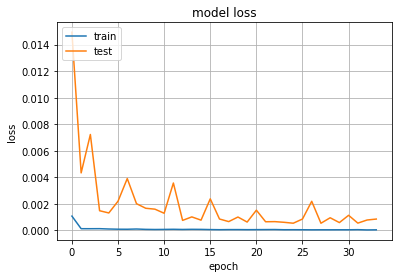

In [ ]:
plt.plot(history.history['loss']) #r
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#model.save_weights('mylstm_weights.h5')

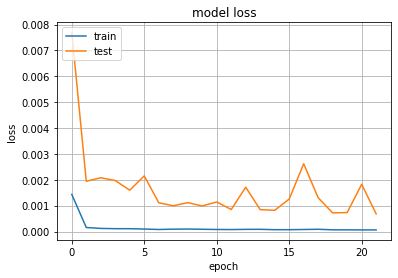

In [109]:
plt.plot(history.history['loss']) # vn
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


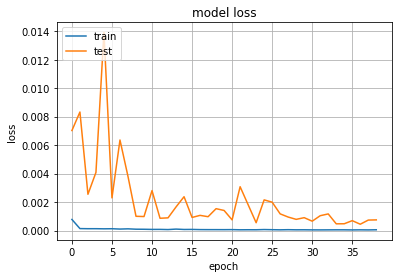

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

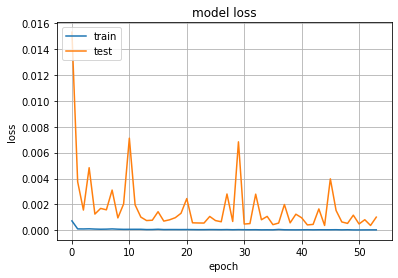

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

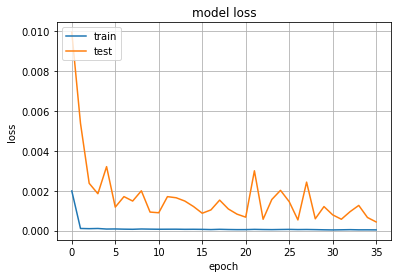

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

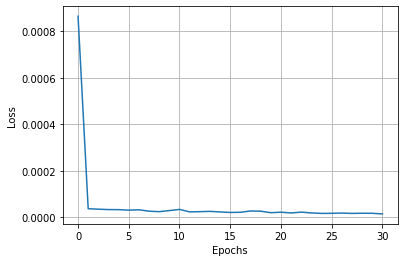

In [ ]:
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

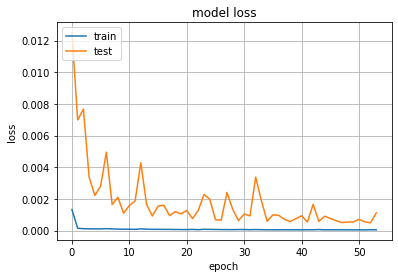

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [110]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [111]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [112]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

21.348368386103683

In [113]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

88.2181916072008

In [ ]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

21.21774883892234

In [ ]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

86.01959140965074

In [ ]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

21.211342928244353

In [ ]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

87.62252121614452

In [ ]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

21.93232696332081

In [ ]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

87.40849010342191

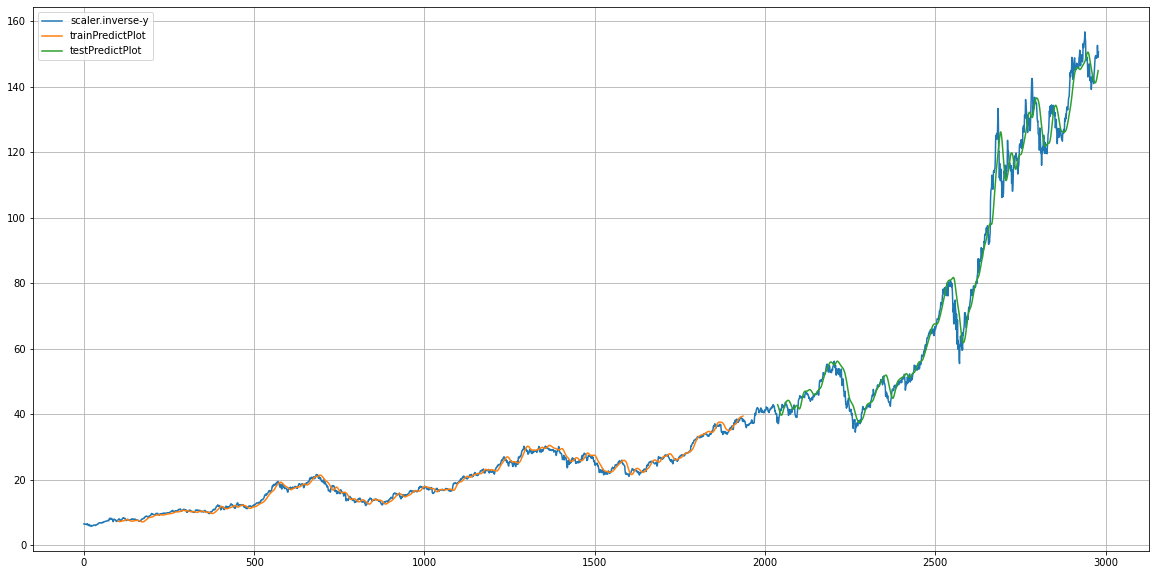

In [114]:
### Plotting 
# shift train predictions for plotting
look_back=100
fig, ax = plt.subplots(figsize=(20,10))
trainPredictPlot = numpy.empty_like(y)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(y)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(y)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(y))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend(['scaler.inverse-y','trainPredictPlot','testPredictPlot'])
plt.show()

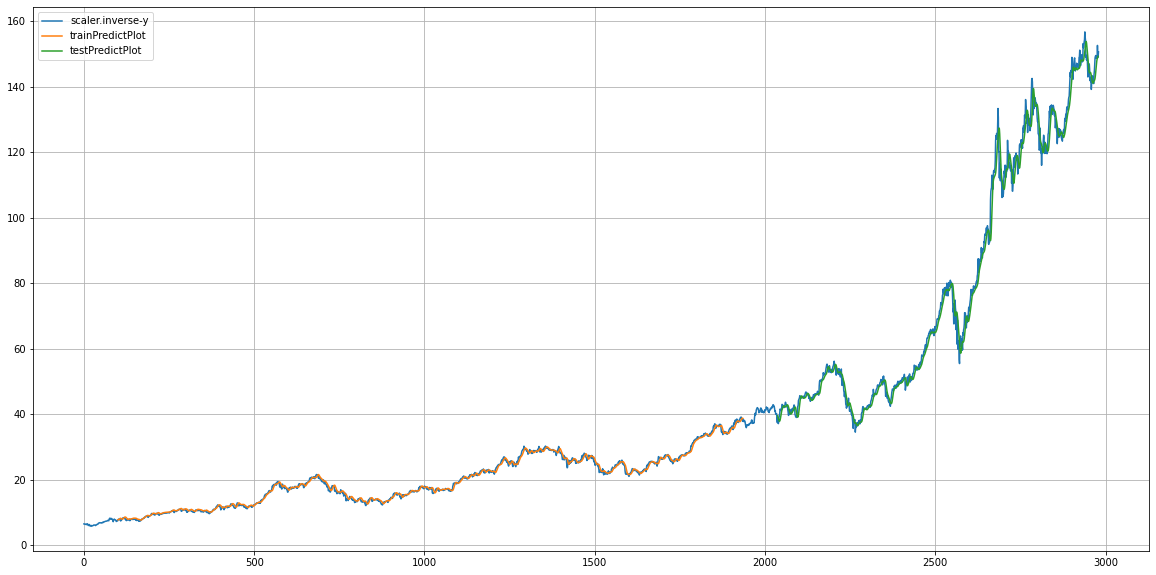

In [ ]:
# shift train predictions for plotting
look_back=100
fig, ax = plt.subplots(figsize=(20,10))
trainPredictPlot = numpy.empty_like(y)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(y)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(y)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(y))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend(['scaler.inverse-y','trainPredictPlot','testPredictPlot'])
plt.show()

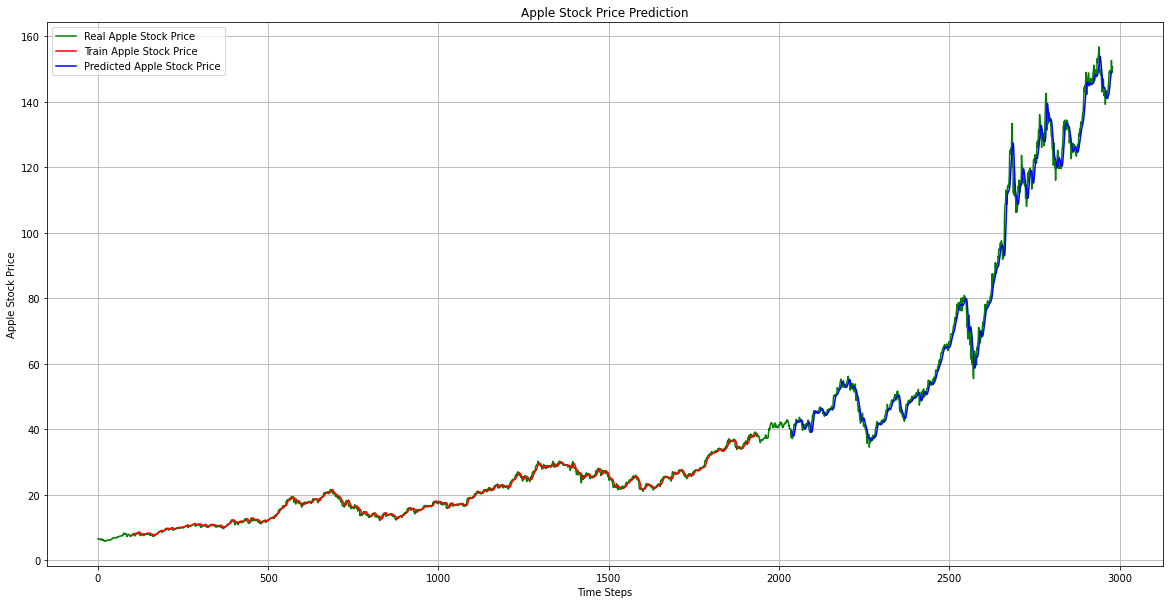

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(scaler.inverse_transform(y), color='Green', label='Real Apple Stock Price')
plt.plot(trainPredictPlot, color='Red', label='Train Apple Stock Price')
plt.plot(testPredictPlot, color='Blue', label='Predicted Apple Stock Price')

plt.title('Apple Stock Price Prediction')
plt.xlabel('Time Steps')
plt.ylabel('Apple Stock Price')
plt.legend()
plt.show()

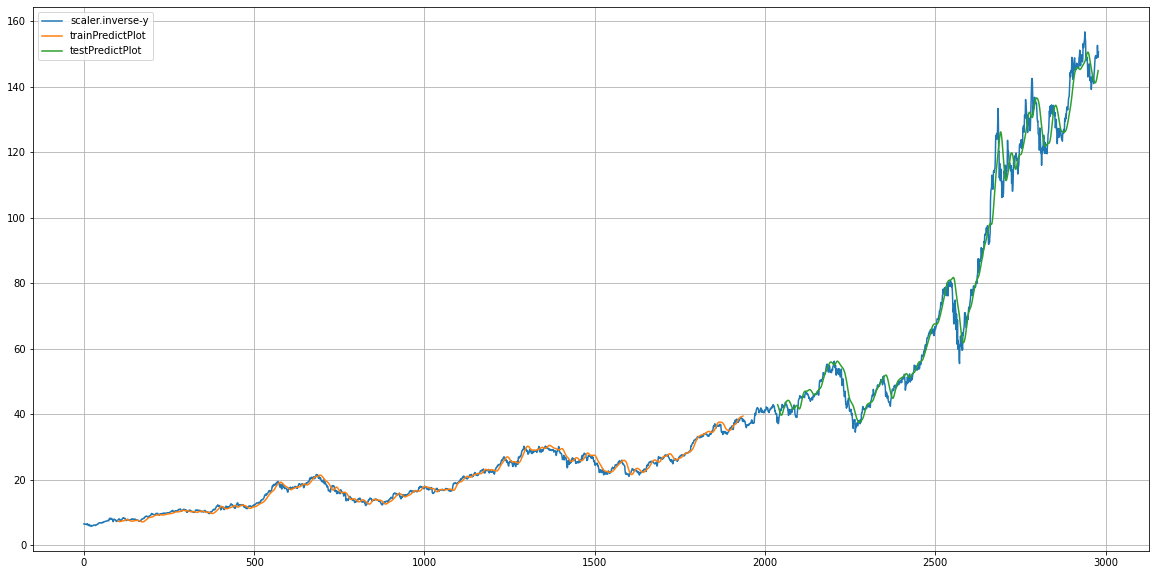

In [115]:
### Plotting 
# shift train predictions for plotting
look_back=100
fig, ax = plt.subplots(figsize=(20,10))
trainPredictPlot = numpy.empty_like(y)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(y)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(y)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(y))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend(['scaler.inverse-y','trainPredictPlot','testPredictPlot'])
plt.show()

In [ ]:

# evaluate the model
train_mse = model.evaluate(X_train, y_train, verbose=1)
test_mse = model.evaluate(X_test, ytest, verbose=1)



30/30 [==============================] - 2s 59ms/step - loss: 7.2528e-04


In [ ]:
train_mse > test_mse

False

In [ ]:
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))

Train: 0.000, Test: 0.001


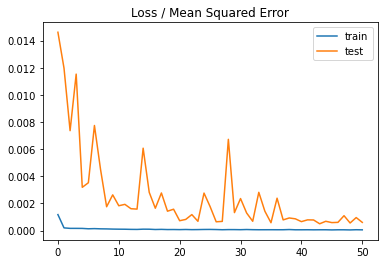

In [ ]:
# plot loss during training
plt.title('Loss / Mean Squared Error')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


In [ ]:
from fbprophet import Prophet

In [ ]:
df11['Adj Close']

0         6.562589
1         6.573936
2         6.469368
3         6.457407
4         6.500340
           ...    
2975    148.850006
2976    152.570007
2977    149.800003
2978    148.960007
2979    150.580002
Name: Adj Close, Length: 2980, dtype: float64

In [ ]:
df11.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2980 entries, 0 to 2979
Data columns (total 13 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Date                                   2980 non-null   object 
 1   Adj Close                              2980 non-null   float64
 2   differenced_trasnformation_demand      2979 non-null   float64
 3   differenced_demand_filled              2980 non-null   float64
 4   differenced_inv_transformation_demand  2980 non-null   float64
 5   date                                   2980 non-null   object 
 6   year                                   2980 non-null   int64  
 7   month                                  2980 non-null   int64  
 8   week                                   2980 non-null   int64  
 9   day                                    2980 non-null   int64  
 10  dayofweek                              2980 non-null   int64  
 11  week

In [ ]:
 bb = df11[['Date','Adj Close']]

In [ ]:
bb.tail()

Date   Adj Close
2975  2021-10-27  148.850006
2976  2021-10-28  152.570007
2977  2021-10-29  149.800003
2978  2021-11-01  148.960007
2979  2021-11-02  150.580002

In [ ]:

aapl_features = bb.rename(columns = {"Date":"ds","Adj Close":"y"})
aapl_features.head()

ds         y
0  2010-01-04  6.562589
1  2010-01-05  6.573936
2  2010-01-06  6.469368
3  2010-01-07  6.457407
4  2010-01-08  6.500340

In [ ]:
aapl_model = Prophet(daily_seasonality = True) # stock prices have daily seasonality
aapl_model.fit(aapl_features)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [ ]:
future = aapl_model.make_future_dataframe(periods = 58) # how many days into the future we want
prediction = aapl_model.predict(future)

In [ ]:
prediction

ds       trend  ...  multiplicative_terms_upper        yhat
0    2010-01-04    6.533377  ...                         0.0    6.841865
1    2010-01-05    6.542235  ...                         0.0    6.868467
2    2010-01-06    6.551094  ...                         0.0    6.853183
3    2010-01-07    6.559953  ...                         0.0    6.814581
4    2010-01-08    6.568812  ...                         0.0    6.697646
...         ...         ...  ...                         ...         ...
3033 2021-12-26  163.360742  ...                         0.0  163.911622
3034 2021-12-27  163.489158  ...                         0.0  164.008820
3035 2021-12-28  163.617575  ...                         0.0  164.163680
3036 2021-12-29  163.745991  ...                         0.0  164.271615
3037 2021-12-30  163.874408  ...                         0.0  164.351062

[3038 rows x 22 columns]

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.offline as py

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=prediction['ds'], y=prediction['yhat'],
                    mode='markers',
                    name='Most Likely'))
fig.add_trace(go.Scatter(x=prediction['ds'], y=prediction['yhat_lower'],
                    mode='lines+markers',
                    name='Pessimistic'))
fig.add_trace(go.Scatter(x=prediction['ds'], y=prediction['yhat_upper'],
                    mode='lines',
                    name='Optimistic'))

fig.add_trace(go.Scatter(x=aapl_features['ds'], y=aapl_features['y'], name='Actual',
                         line = dict(color='goldenrod')))
fig.show()

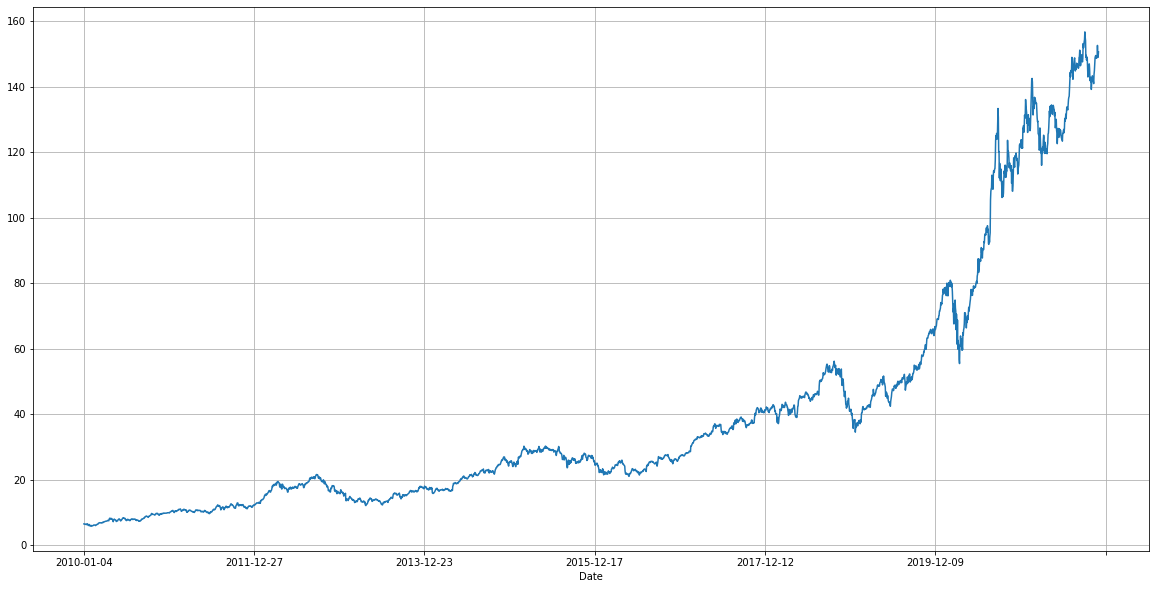

In [ ]:
df11.set_index('Date')['Adj Close'].plot(figsize=FIGURE_SIZE)

# Neuralprophet

In [ ]:
!pip install neuralprophet

In [116]:
pip install neuralprophet[live]

     |████████████████████████████████| 67 kB 2.3 MB/s 
     |████████████████████████████████| 155 kB 18.7 MB/s 
  Attempting uninstall: holidays
    Found existing installation: holidays 0.10.5.2
    Uninstalling holidays-0.10.5.2:
      Successfully uninstalled holidays-0.10.5.2


In [117]:
import pandas as pd
from neuralprophet import NeuralProphet

In [118]:
df11 = pd.read_csv("stock.csv")
df11.head()

Date  Adj Close  ...  week_of_month  is_weekend
0  2010-01-04   6.562589  ...              1           0
1  2010-01-05   6.573936  ...              1           0
2  2010-01-06   6.469368  ...              1           0
3  2010-01-07   6.457407  ...              1           0
4  2010-01-08   6.500340  ...              2           0

[5 rows x 13 columns]

In [119]:
cc = df11[['Date','Adj Close']]
aapl_feature = cc.rename(columns = {"Date":"ds","Adj Close":"y"})
aapl_feature.head()

ds         y
0  2010-01-04  6.562589
1  2010-01-05  6.573936
2  2010-01-06  6.469368
3  2010-01-07  6.457407
4  2010-01-08  6.500340

In [ ]:
#model = NeuralProphet(daily_seasonality=False)
model = NeuralProphet()

In [ ]:
metrics = model.fit(aapl_feature, 
                    freq='D', epochs=1000)

INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32


  0%|          | 0/273 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.11E-02, min: 1.40E+00


  0%|          | 0/273 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.11E-02, min: 1.51E+00


  0%|          | 0/273 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.11E-02, min: 1.40E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 3.11E-02
Epoch[1000/1000]: 100%|██████████| 1000/1000 [03:34<00:00,  4.66it/s, SmoothL1Loss=0.000624, MAE=2.91, RMSE=4.28, RegLoss=0]


In [ ]:
forecast = model.predict(aapl_feature)

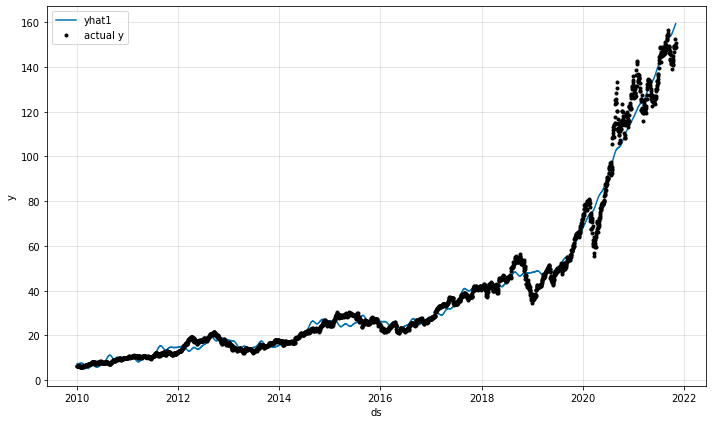

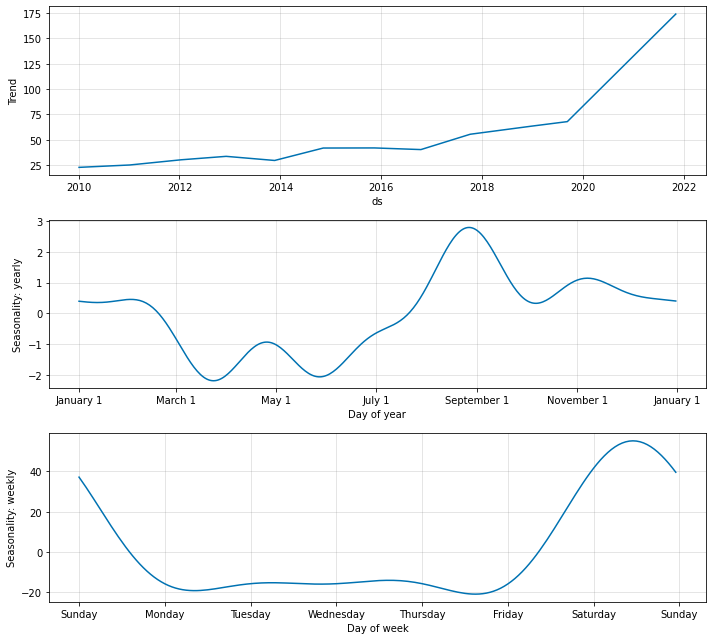

In [ ]:
fig_forecast = model.plot(forecast)
fig_components = model.plot_components(forecast)
#fig_model = model.plot_parameters()


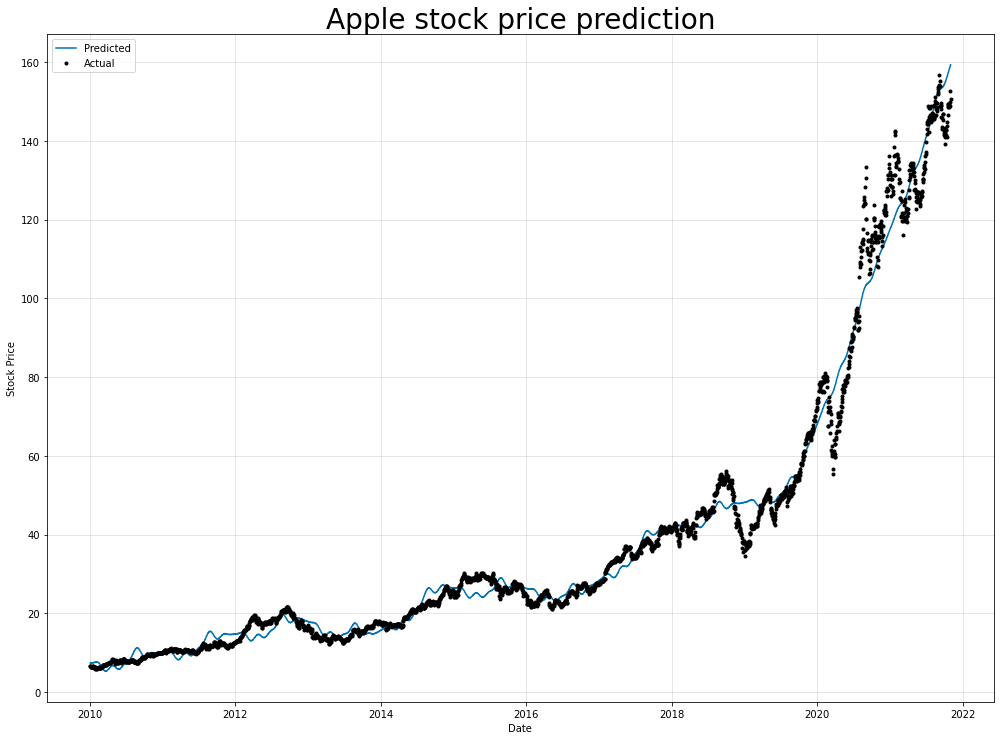

In [ ]:
fig, ax = plt.subplots(figsize=(14, 10)) 
model.plot(forecast, xlabel="Date", ylabel="Stock Price", ax=ax)
ax.set_title("Apple stock price prediction", fontsize=28)
ax.legend(['Predicted', 'Actual'])

Text(0.5, 0, 'epoch')

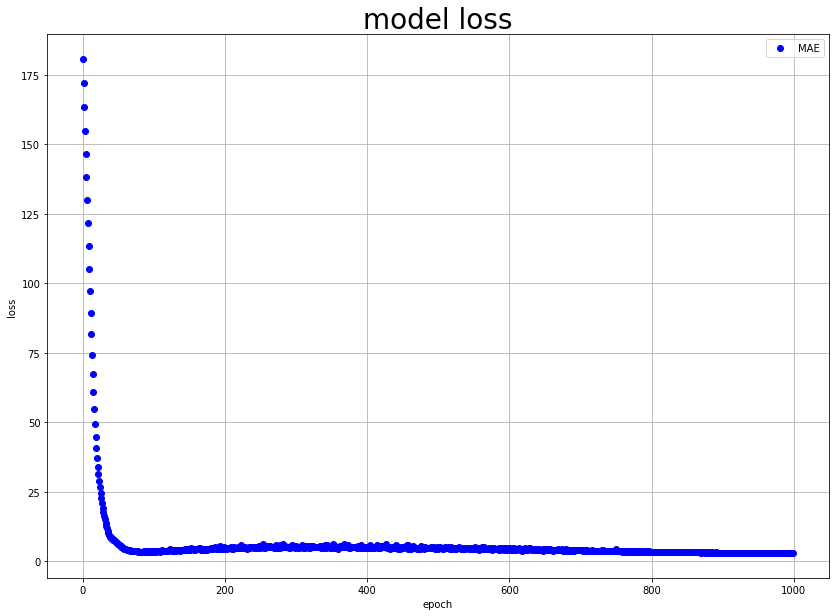

In [ ]:
fig, ax = plt.subplots(figsize=(14, 10))
ax.plot(metrics["MAE"], 'ob', linewidth=6, label="Training Loss")  
#ax.plot(metrics["SmoothL1Loss"], '-r', linewidth=2, label="Validation Loss")
ax.legend(['MAE'])
ax.set_title("model loss", fontsize=28)
plt.ylabel('loss')
plt.xlabel('epoch')

In [ ]:
m = NeuralProphet()
df_train, df_test = m.split_df(aapl_feature, valid_p=0.3,freq='D')

In [ ]:
# train_metrics = m.fit(df_train,freq='D',epochs=1000)
# test_metrics = m.test(df_test)

In [ ]:
#m = NeuralProphet()
metricss = m.fit(df_train, validation_df=df_test , freq='D',epochs=1000, plot_live_loss=False)

INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32


  0%|          | 0/271 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.01E-02, min: 1.58E+00


  0%|          | 0/271 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.41E-02, min: 1.26E+00


  0%|          | 0/271 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.69E-02, min: 1.47E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 3.98E-02
Epoch[1000/1000]: 100%|██████████| 1000/1000 [02:47<00:00,  5.97it/s, SmoothL1Loss=0.00261, MAE=2.69, RMSE=4.44, RegLoss=0, MAE_val=30.4, RMSE_val=31.1, SmoothL1Loss_val=0.116]


In [ ]:
forecast = m.predict(df_train)

Text(0.5, 1.0, 'Apple stock price prediction')

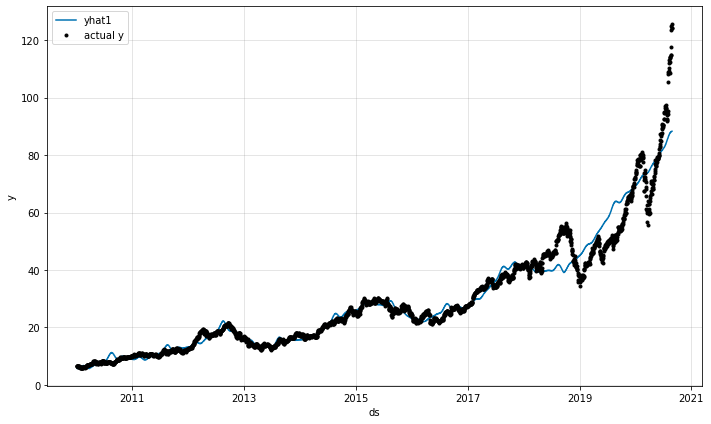

In [ ]:
fig_forecast = m.plot(forecast)
ax.set_title("Apple stock price prediction", fontsize=28)
#ax.legend(['Predicted', 'Actual'])
#fig_components = model.plot_components(forecast)
#fig_model = model.plot_parameters()

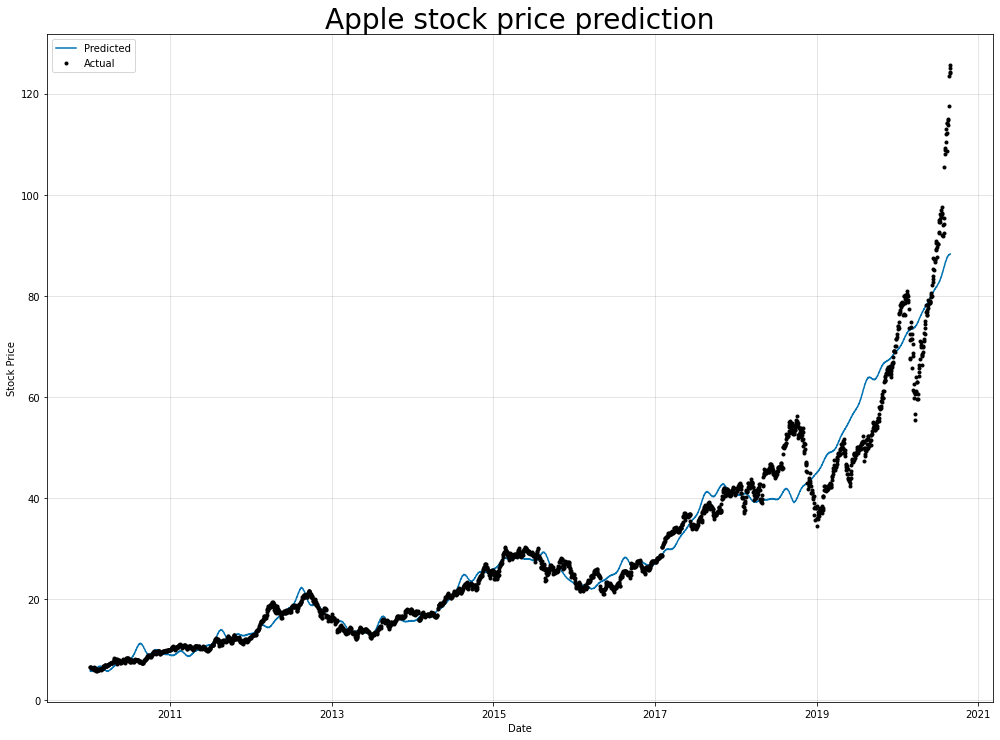

In [ ]:
fig, ax = plt.subplots(figsize=(14, 10)) 
m.plot(forecast, xlabel="Date", ylabel="Stock Price", ax=ax)
ax.set_title("Apple stock price prediction", fontsize=28)
ax.legend(['Predicted', 'Actual'])

Text(0.5, 0, 'epoch')

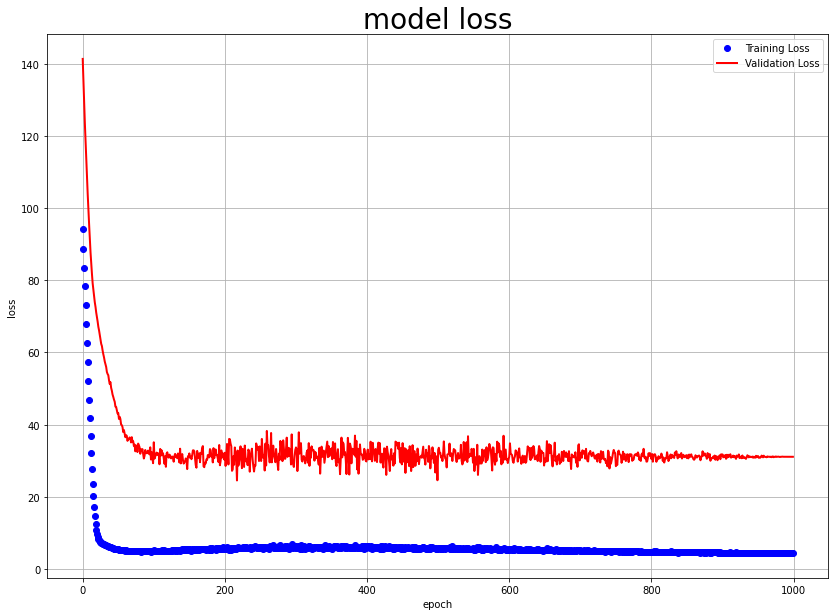

In [ ]:
fig, ax = plt.subplots(figsize=(14, 10))
ax.plot(metricss["RMSE"], 'ob', linewidth=6, label="Training Loss")  
ax.plot(metricss["RMSE_val"], '-r', linewidth=2, label="Validation Loss")
ax.legend(['RMSE', 'RMSE_val'])
ax.set_title("model loss", fontsize=28)
ax.legend(['Training Loss', 'Validation Loss'])
plt.ylabel('loss')
plt.xlabel('epoch')

In [ ]:
# from neuralprophet import set_random_seed 
# set_random_seed(0)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

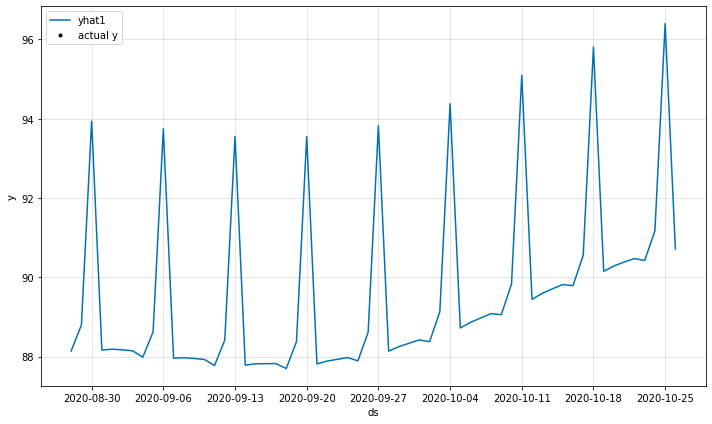

In [ ]:
f_future = m.make_future_dataframe(df_train, periods=60)
forecast = m.predict(f_future)
fig_forecast = m.plot(forecast)